# Random Forest and Gradient Boosting regressors

By O. Ianucci and N. Matsnev
We gotta fill it with text and explanations of graphs, BRO SEE IT PLS

## 1. Parsing data set

In [1]:
#importing the used libs and 
#then checking our raw primary data
import math
from scipy import stats
from scipy.io import loadmat
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression        
from sklearn.tree import export_graphviz
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def string_to_int(val_list):
    uniq = list(set(val_list))
    int_vals = [0] * len(val_list)
    for i in range(0,len(val_list)):
        for j in range(0,len(uniq)):
            if val_list[i] == uniq[j]:
                int_vals[i] = j
    return int_vals


row_data = pd.read_excel('vgsales_mod_year.xlsx')
print("nan values per column")
print(row_data.isna().sum())
#what we can see is that we have nan only in year
#and publisher, 
vgsales = row_data
#the table is clearly intended to be up to 2016, 
#but some people decided to fill it after a bit
#resulting in not categorised 
#or years which are after 2016
vgsales['Year'] = row_data['Year'].replace(np.nan, 2017).replace(2017, 2017).replace(2020, 2017)
#there are many publishers, however, some are
#uncategorised so we fill it with the huge value
#so when we have converted each publisher to 
#its numerical analogue, we wouldn't have
#impure data, e.g. in a way that regressors learnt
# to react on publisher 10000, it would not use
# the experience to predict on other publisher
vgsales['Publisher'] = row_data['Publisher'].replace(np.nan, 10001)
print("vgsales")
print(vgsales.head())

nan values per column
Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64
vgsales
   Rank             Name Platform    Year     Genre   Publisher  NA_Sales  \
0   259        Asteroids     2600  1980.0   Shooter       Atari      4.00   
1   545  Missile Command     2600  1980.0   Shooter       Atari      2.56   
2  1768          Kaboom!     2600  1980.0      Misc  Activision      1.07   
3  1971         Defender     2600  1980.0      Misc       Atari      0.99   
4  2671           Boxing     2600  1980.0  Fighting  Activision      0.72   

   EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0      0.26       0.0         0.05          4.31  
1      0.17       0.0         0.03          2.76  
2      0.07       0.0         0.01          1.15  
3      0.05       0.0         0.01          1.05  
4      0.04       0

# 2. Preprocessing data

## 2.1. Data Modification 
Here we modify data so it would be nicer for regression purposes
with regard to the already implemented by sklearn tools
it is always better to use integer rather than strings.

In [2]:
platforms = string_to_int(vgsales['Platform'].tolist())
years = vgsales['Year'].tolist()
genres = string_to_int(vgsales['Genre'].tolist())
publishers = string_to_int(vgsales['Publisher'].tolist())
eu_sales = vgsales['NA_Sales'].tolist()
na_sales = vgsales['EU_Sales'].tolist()

y = vgsales.iloc[0:, 10].to_numpy().ravel()
X = np.c_[ platforms, years, genres, publishers, ] 
#np.insert(X, 0, platforms, axis=1)
#np.insert(X, 1, years, axis=1) 
#np.insert(X, 2, genres, axis=1)
#np.insert(X, 3, publishers, axis=1)
#np.insert(X, 4, eu_sales, axis=1)
#np.insert(X, 5, na_sales, axis=1)
print(X[0:5,0:4])

[[  14. 1980.    4.  294.]
 [  14. 1980.    4.  294.]
 [  14. 1980.    8.  317.]
 [  14. 1980.    8.  294.]
 [  14. 1980.    3.  317.]]


# 3. Random Forest Regressor
## 3.1 Implementation

Here we use library module for regressor of Random Forest, also based on the attributes importance we make better prediction.

Variable: years                Importance: 0.41
Variable: genres               Importance: 0.25
Variable: publishers           Importance: 0.2
Variable: platforms            Importance: 0.14


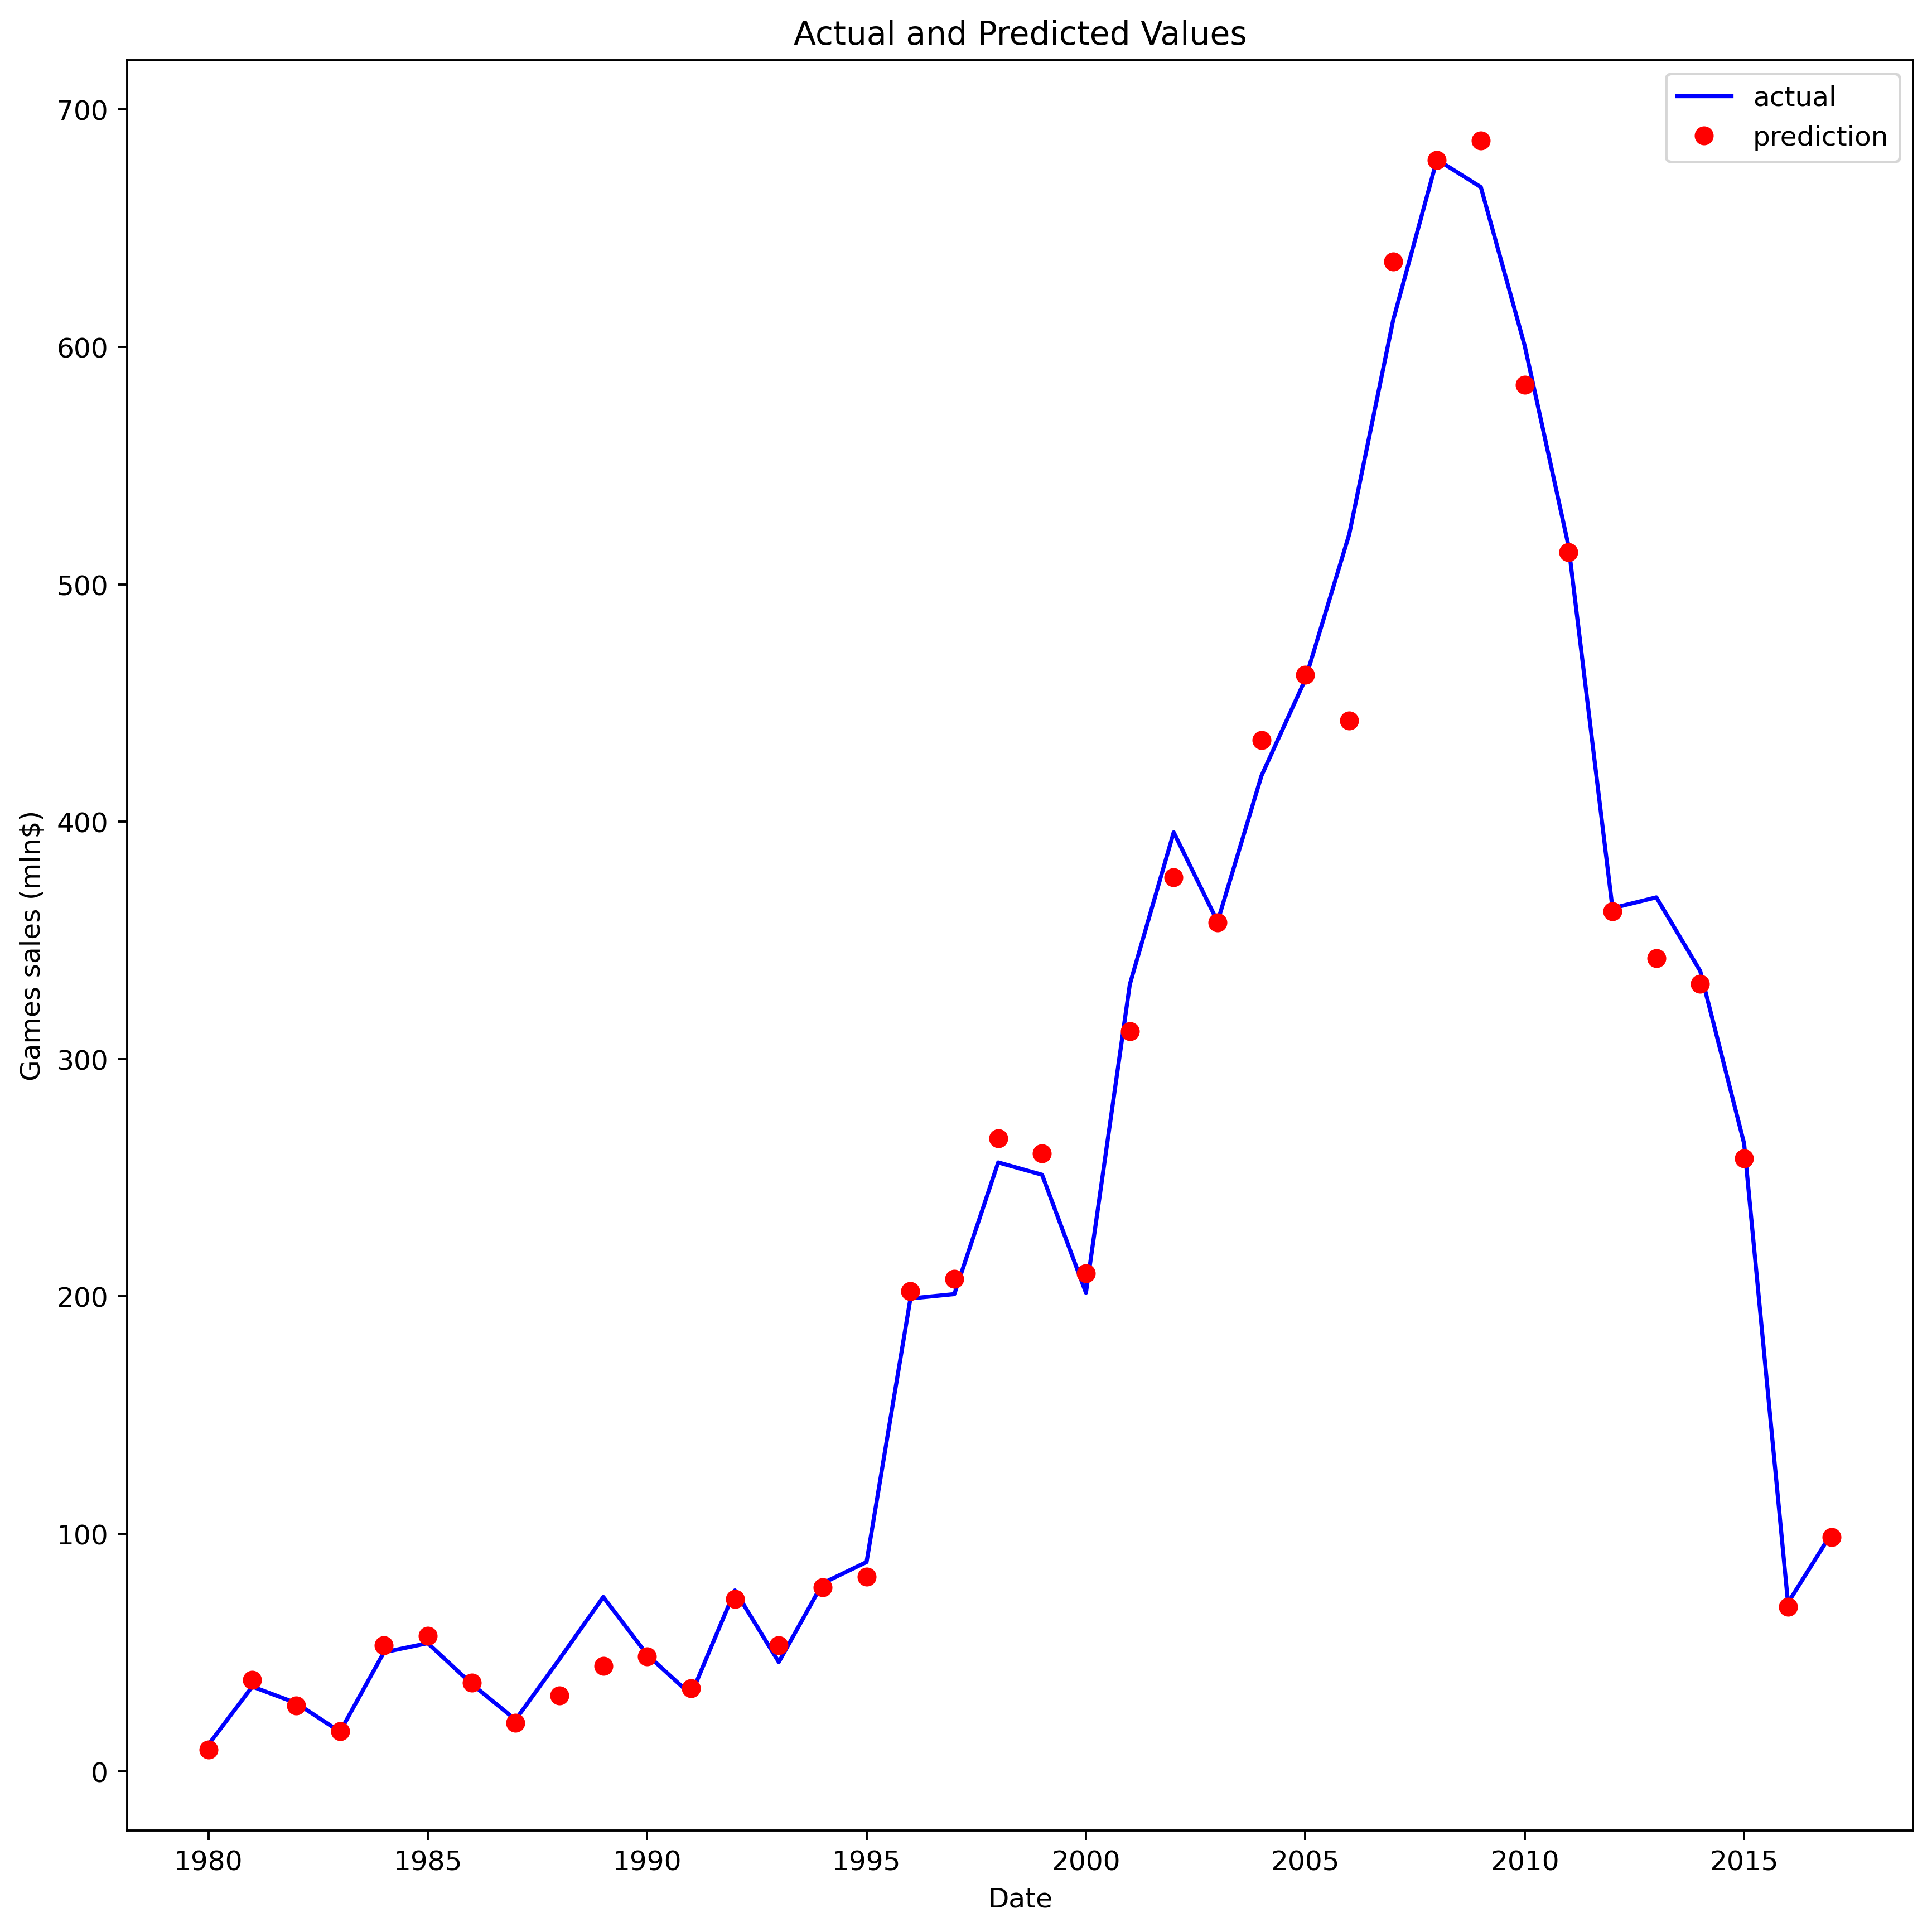

In [3]:
#new

# function to get unique values
def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list
     



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.17, random_state = 42)
regr = RandomForestRegressor(n_estimators = 2000, random_state = 42)
regr.fit(X_train, y_train)

        
# Get numerical feature importances
importances = list(regr.feature_importances_)
# List of tuples with variable and importance
feature_list = ['platforms', 'years', 'genres', 'publishers']
feature_importances_rf = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances_rf = sorted(feature_importances_rf, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_rf];



# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 16000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('genres'), feature_list.index('years')]
train_important = X_train[:, important_indices]
test_important = X_test[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, y_train)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)


predictions_data_rf = rf_most_important.predict(X[:, important_indices])


yrs = unique(years)
sum_by_years_actual_rf = []
sum_by_years_pred_rf = []
for i in yrs:
    indices = [k for k, x in enumerate(years) if x == i]
    sum_by_years_actual_rf.append(np.sum(y[indices[0]:indices[len(indices) - 1]]))
    sum_by_years_pred_rf.append(np.sum(predictions_data_rf[indices[0]:indices[len(indices) - 1]]))
    
fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True)    
# Plot the actual values
plt.plot(yrs, sum_by_years_actual_rf, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(yrs, sum_by_years_pred_rf, 'ro', label = 'prediction')
#plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Games sales (mln$)'); plt.title('Actual and Predicted Values');

## 3.2 Description

### 3.2.1 Residual Scatter plot


The points in a residual plot are not randomly dispersed around the horizontal axis, thus making it applicable for our model.

Text(0.5, 1.0, 'Residual plot of Random Forest')

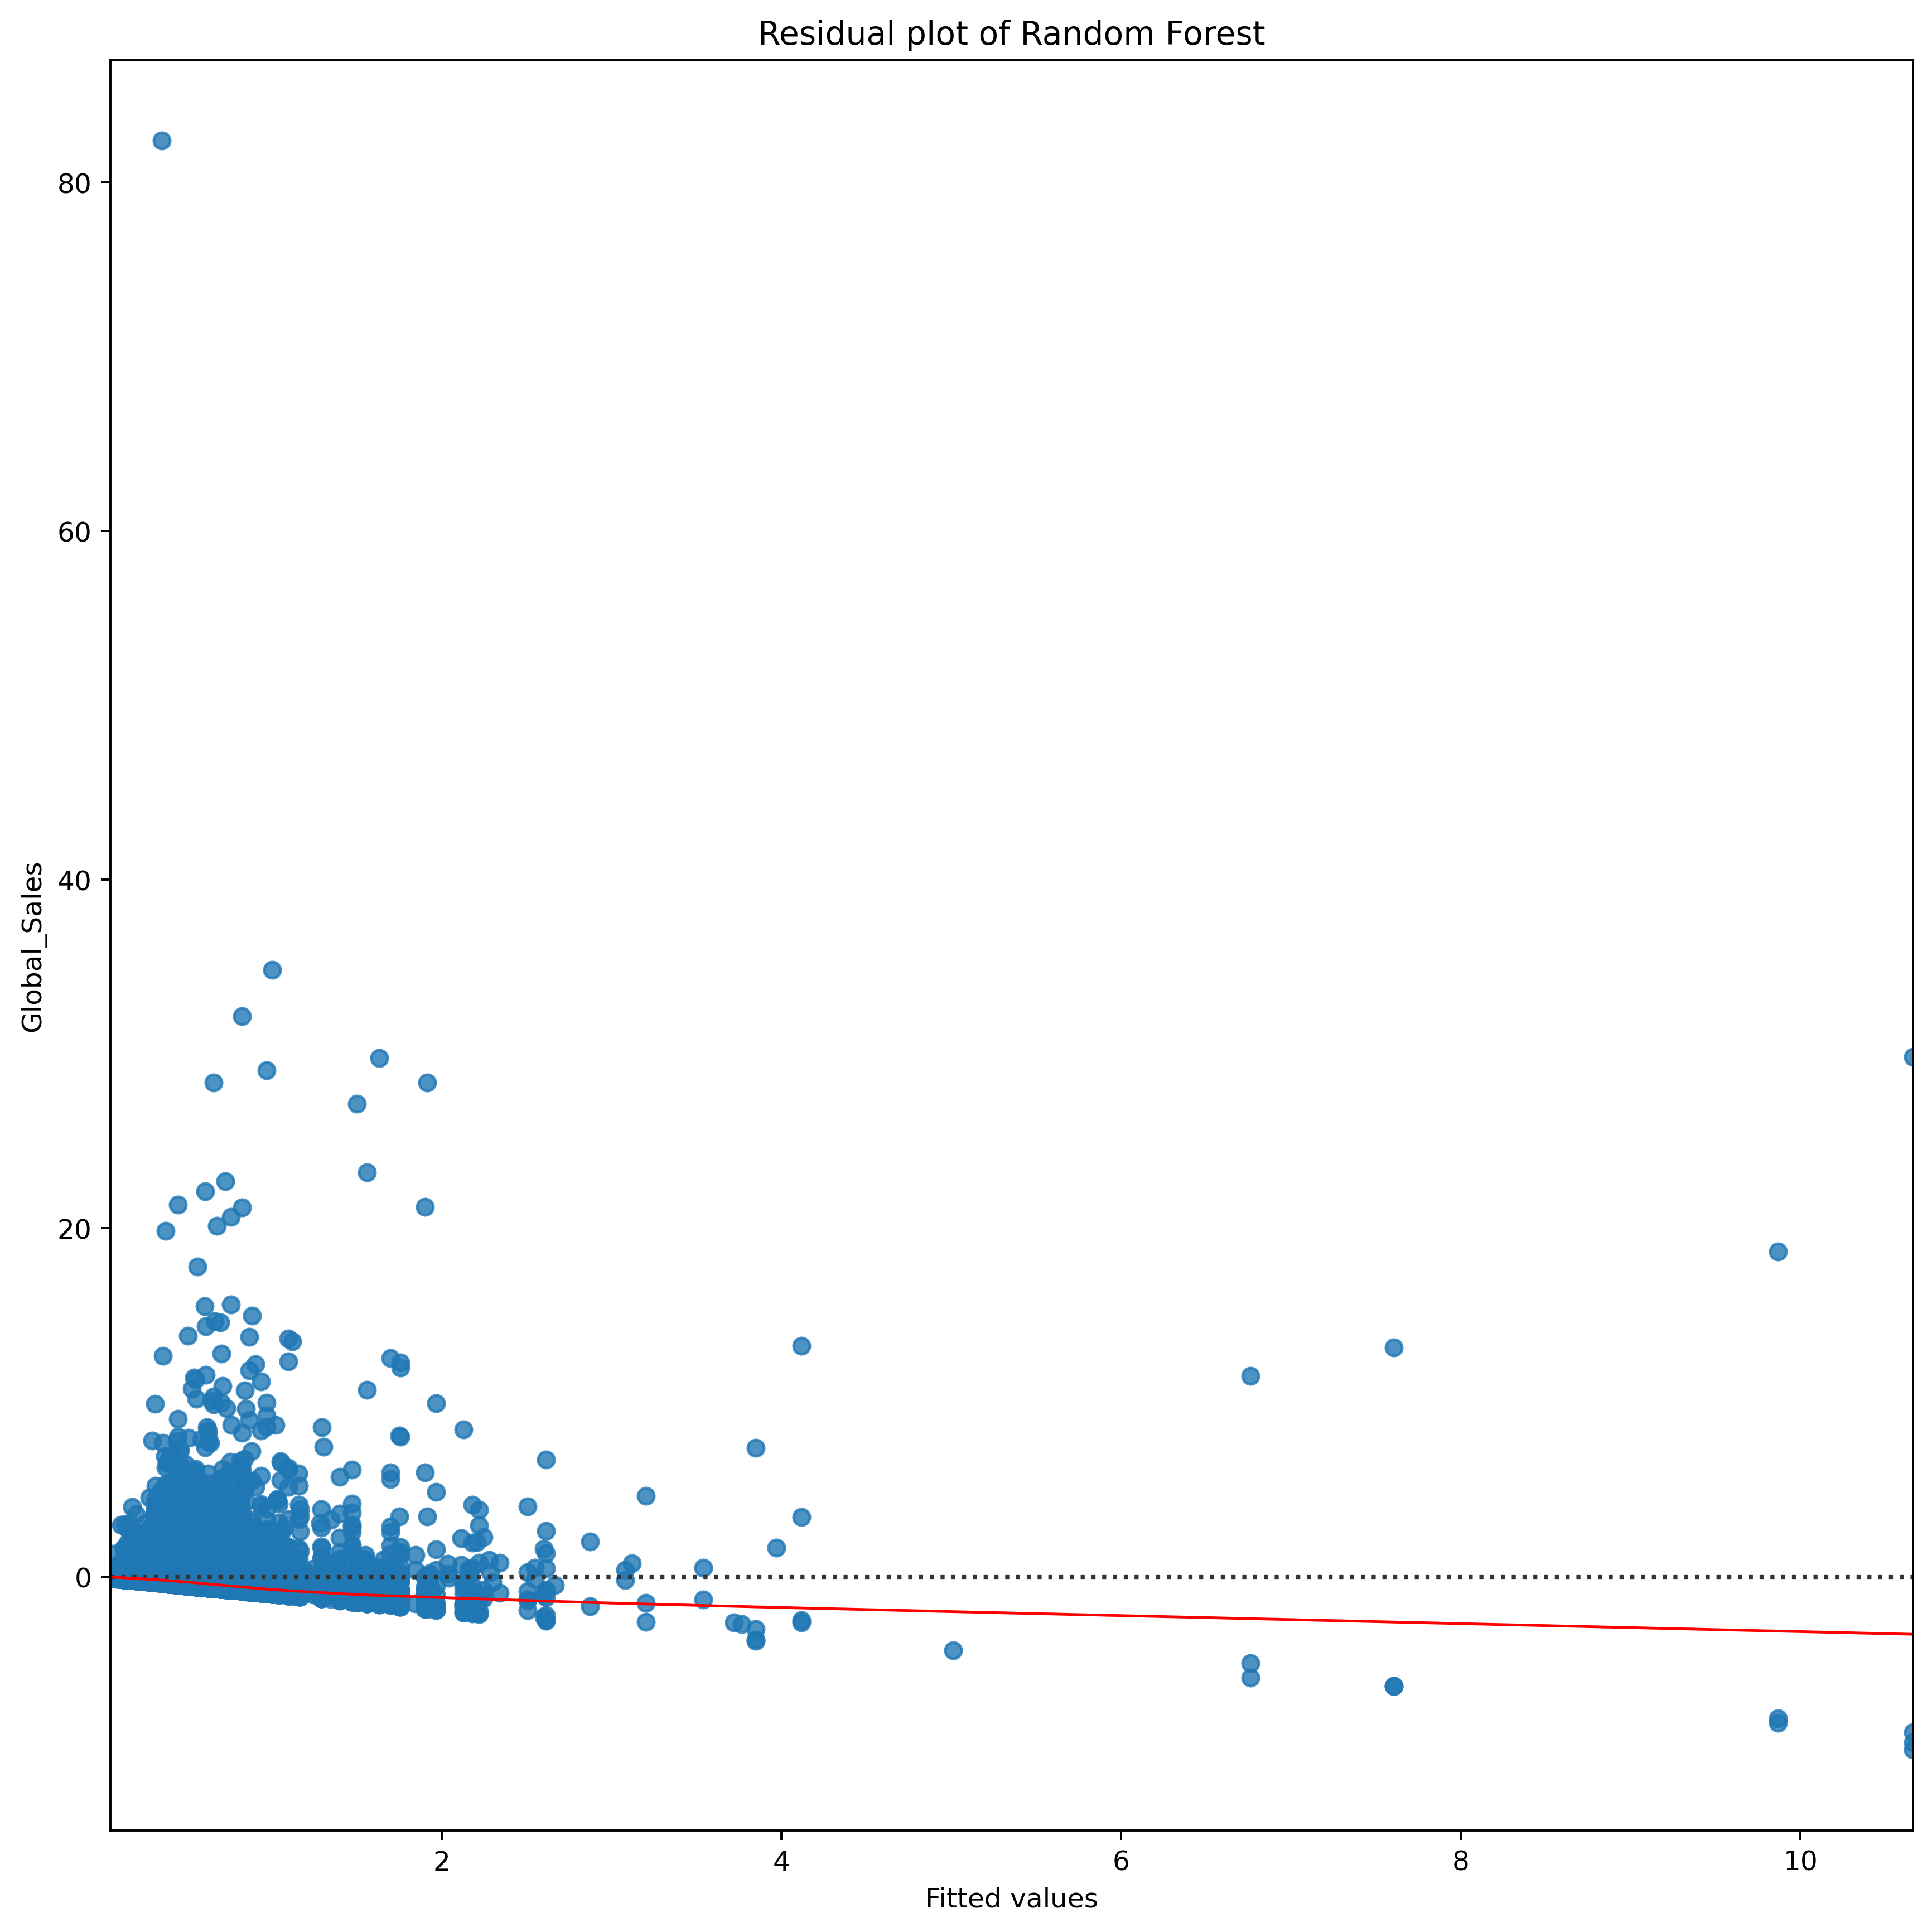

In [4]:

fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True)  
sn.residplot(x=predictions_data_rf, y='Global_Sales', data=vgsales, lowess=True, dropna=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot of Random Forest')



### 3.2.2. QQ plot

If the prediction is correct, the points should fall approximately along this reference line.

Text(0.5, 1.0, 'Normal Q-Q Plot of Random Forest')

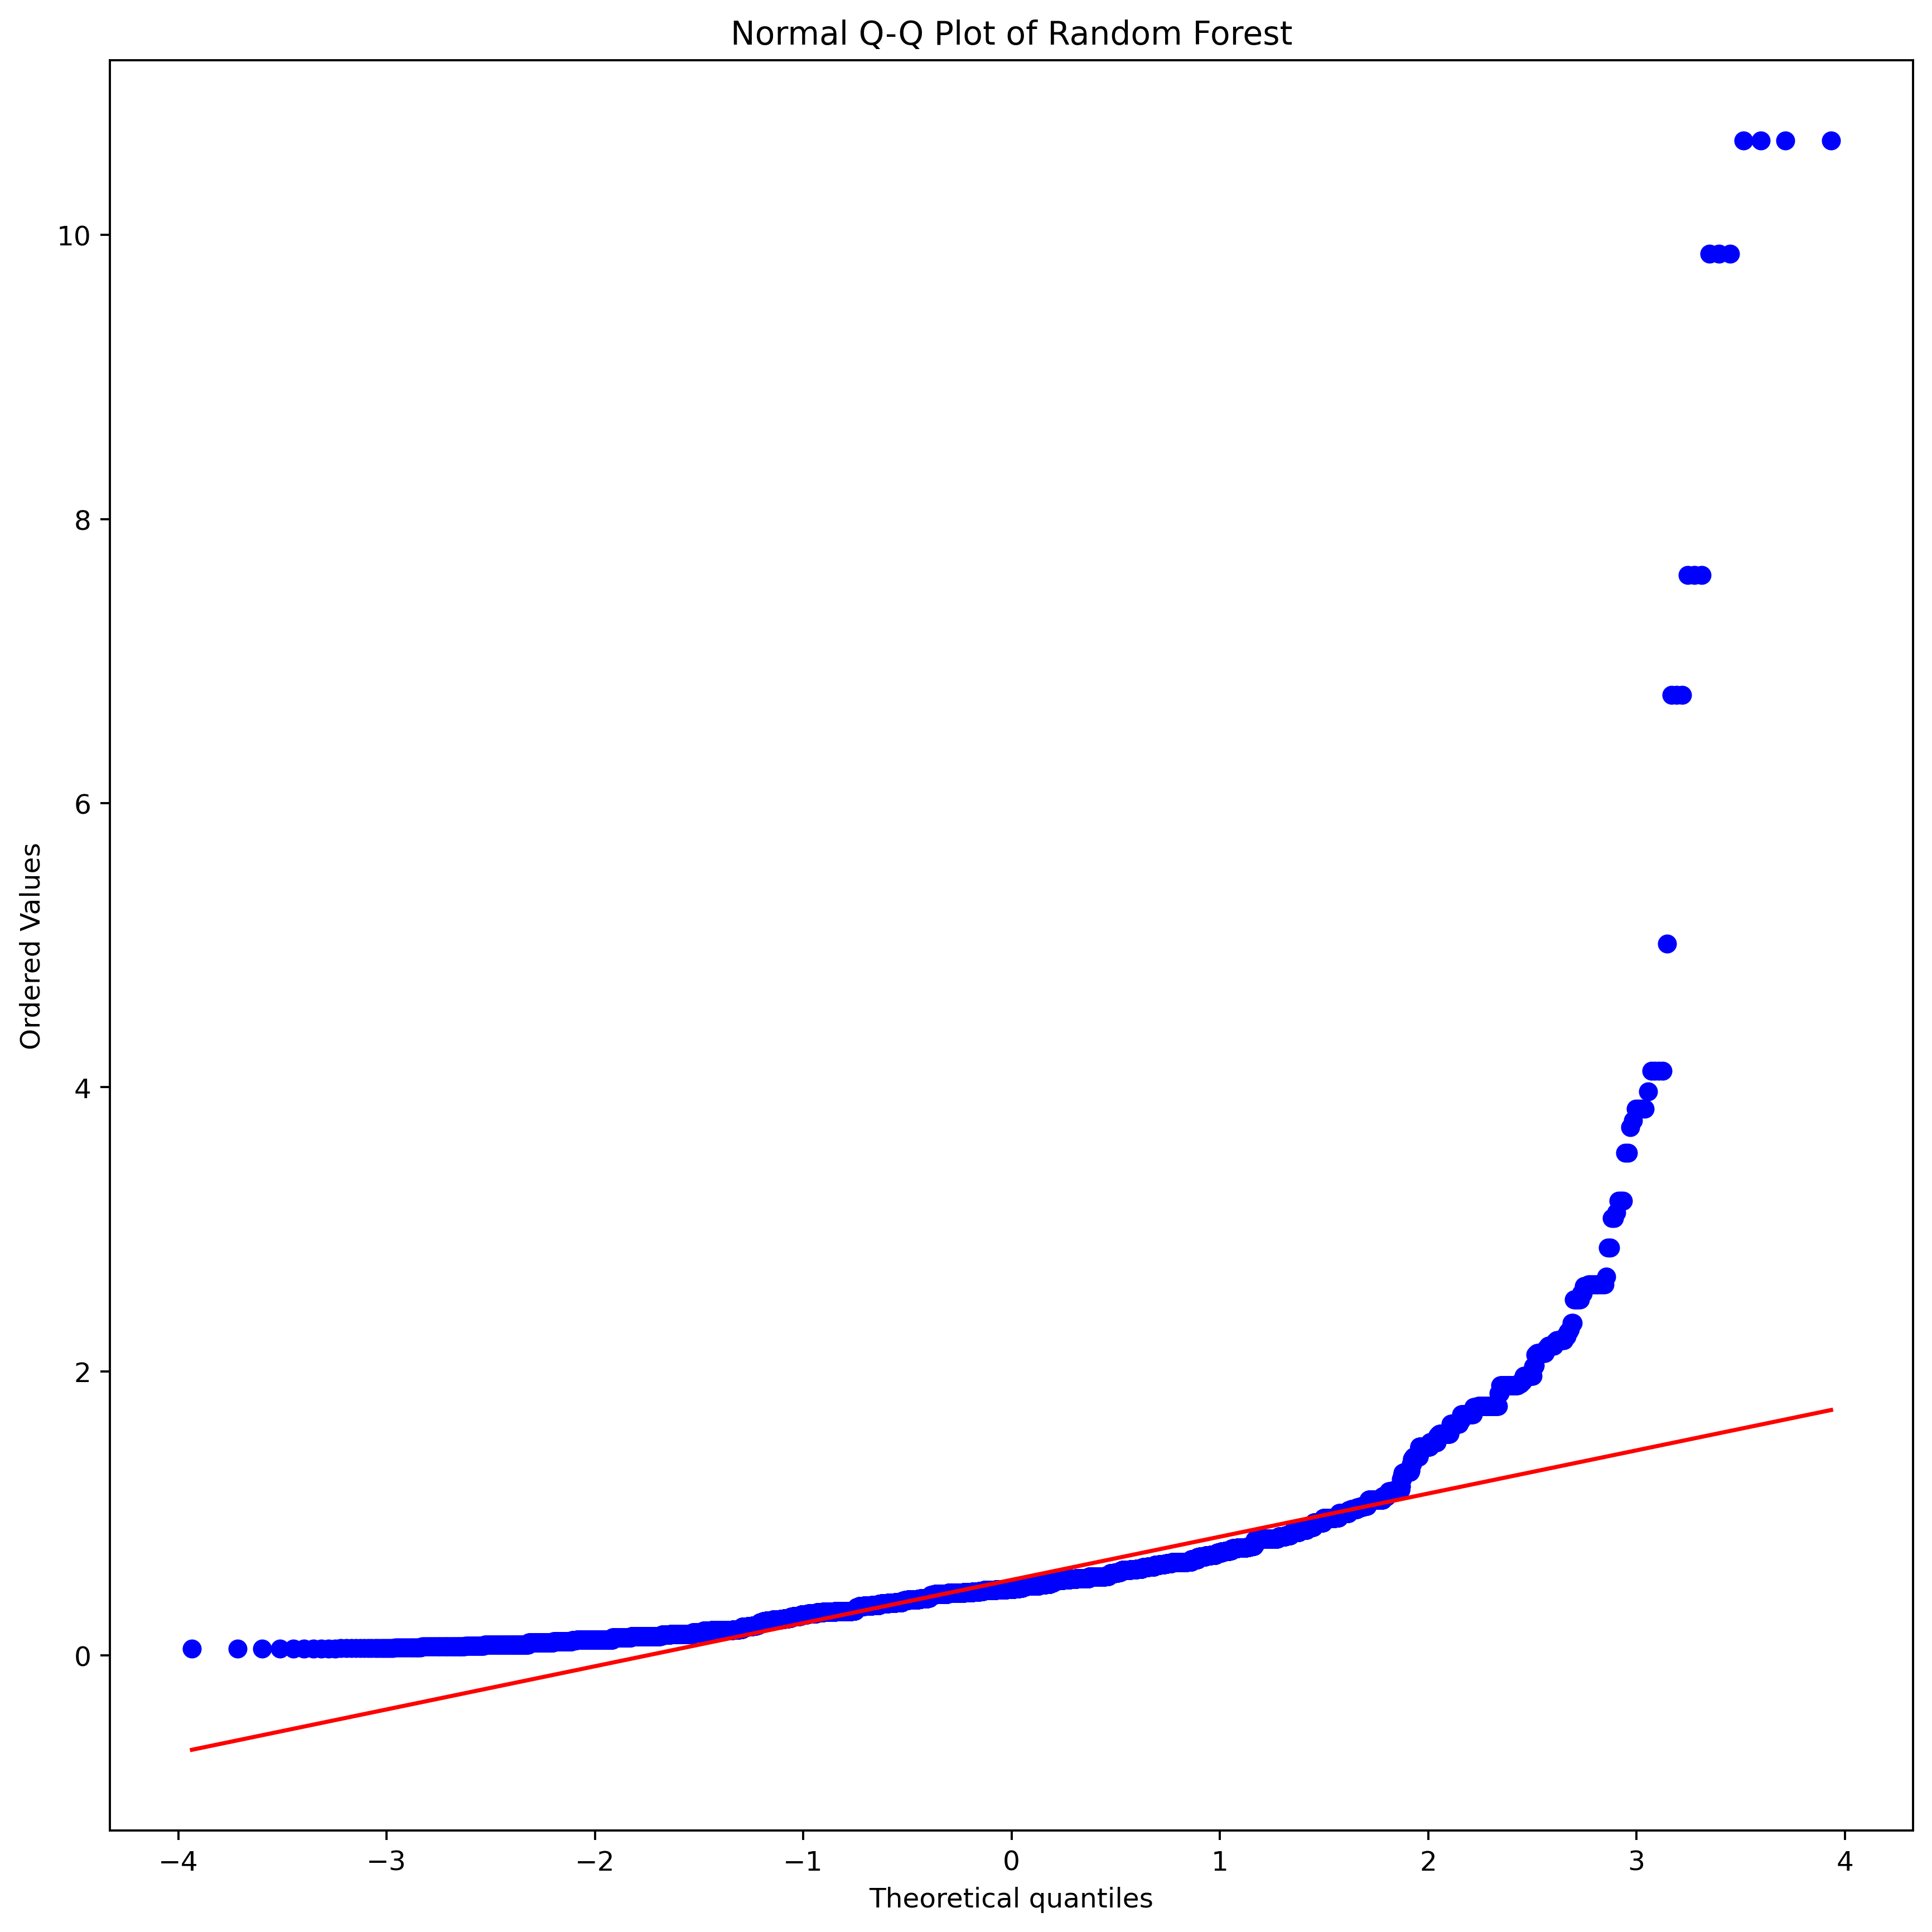

In [6]:

fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True) 
stats.probplot(predictions_data_rf, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot of Random Forest")

### 3.2.3. MSE

We can see that it is quiet low and it is good. Over the time of fitting and training, MSE is constantly decreasing and the final result is comparable with the other method.

>4.3, 2.1 = 4.817
>1.4, 0.5 = 0.978
>1.7, 0.5 = 1.270
>0.5, 0.6 = 0.020
>0.2, 0.5 = 0.059
>0.1, 0.2 = 0.032
>0.0, 0.5 = 0.176
>0.0, 0.7 = 0.402
>0.1, 0.6 = 0.309
>0.2, 0.7 = 0.225
>0.6, 0.4 = 0.028
>0.0, 0.2 = 0.014
>0.1, 0.4 = 0.133
>0.1, 0.6 = 0.172
>0.1, 0.6 = 0.216
>0.3, 0.5 = 0.062
>0.8, 0.2 = 0.440
number of taken elems for MSE is 166


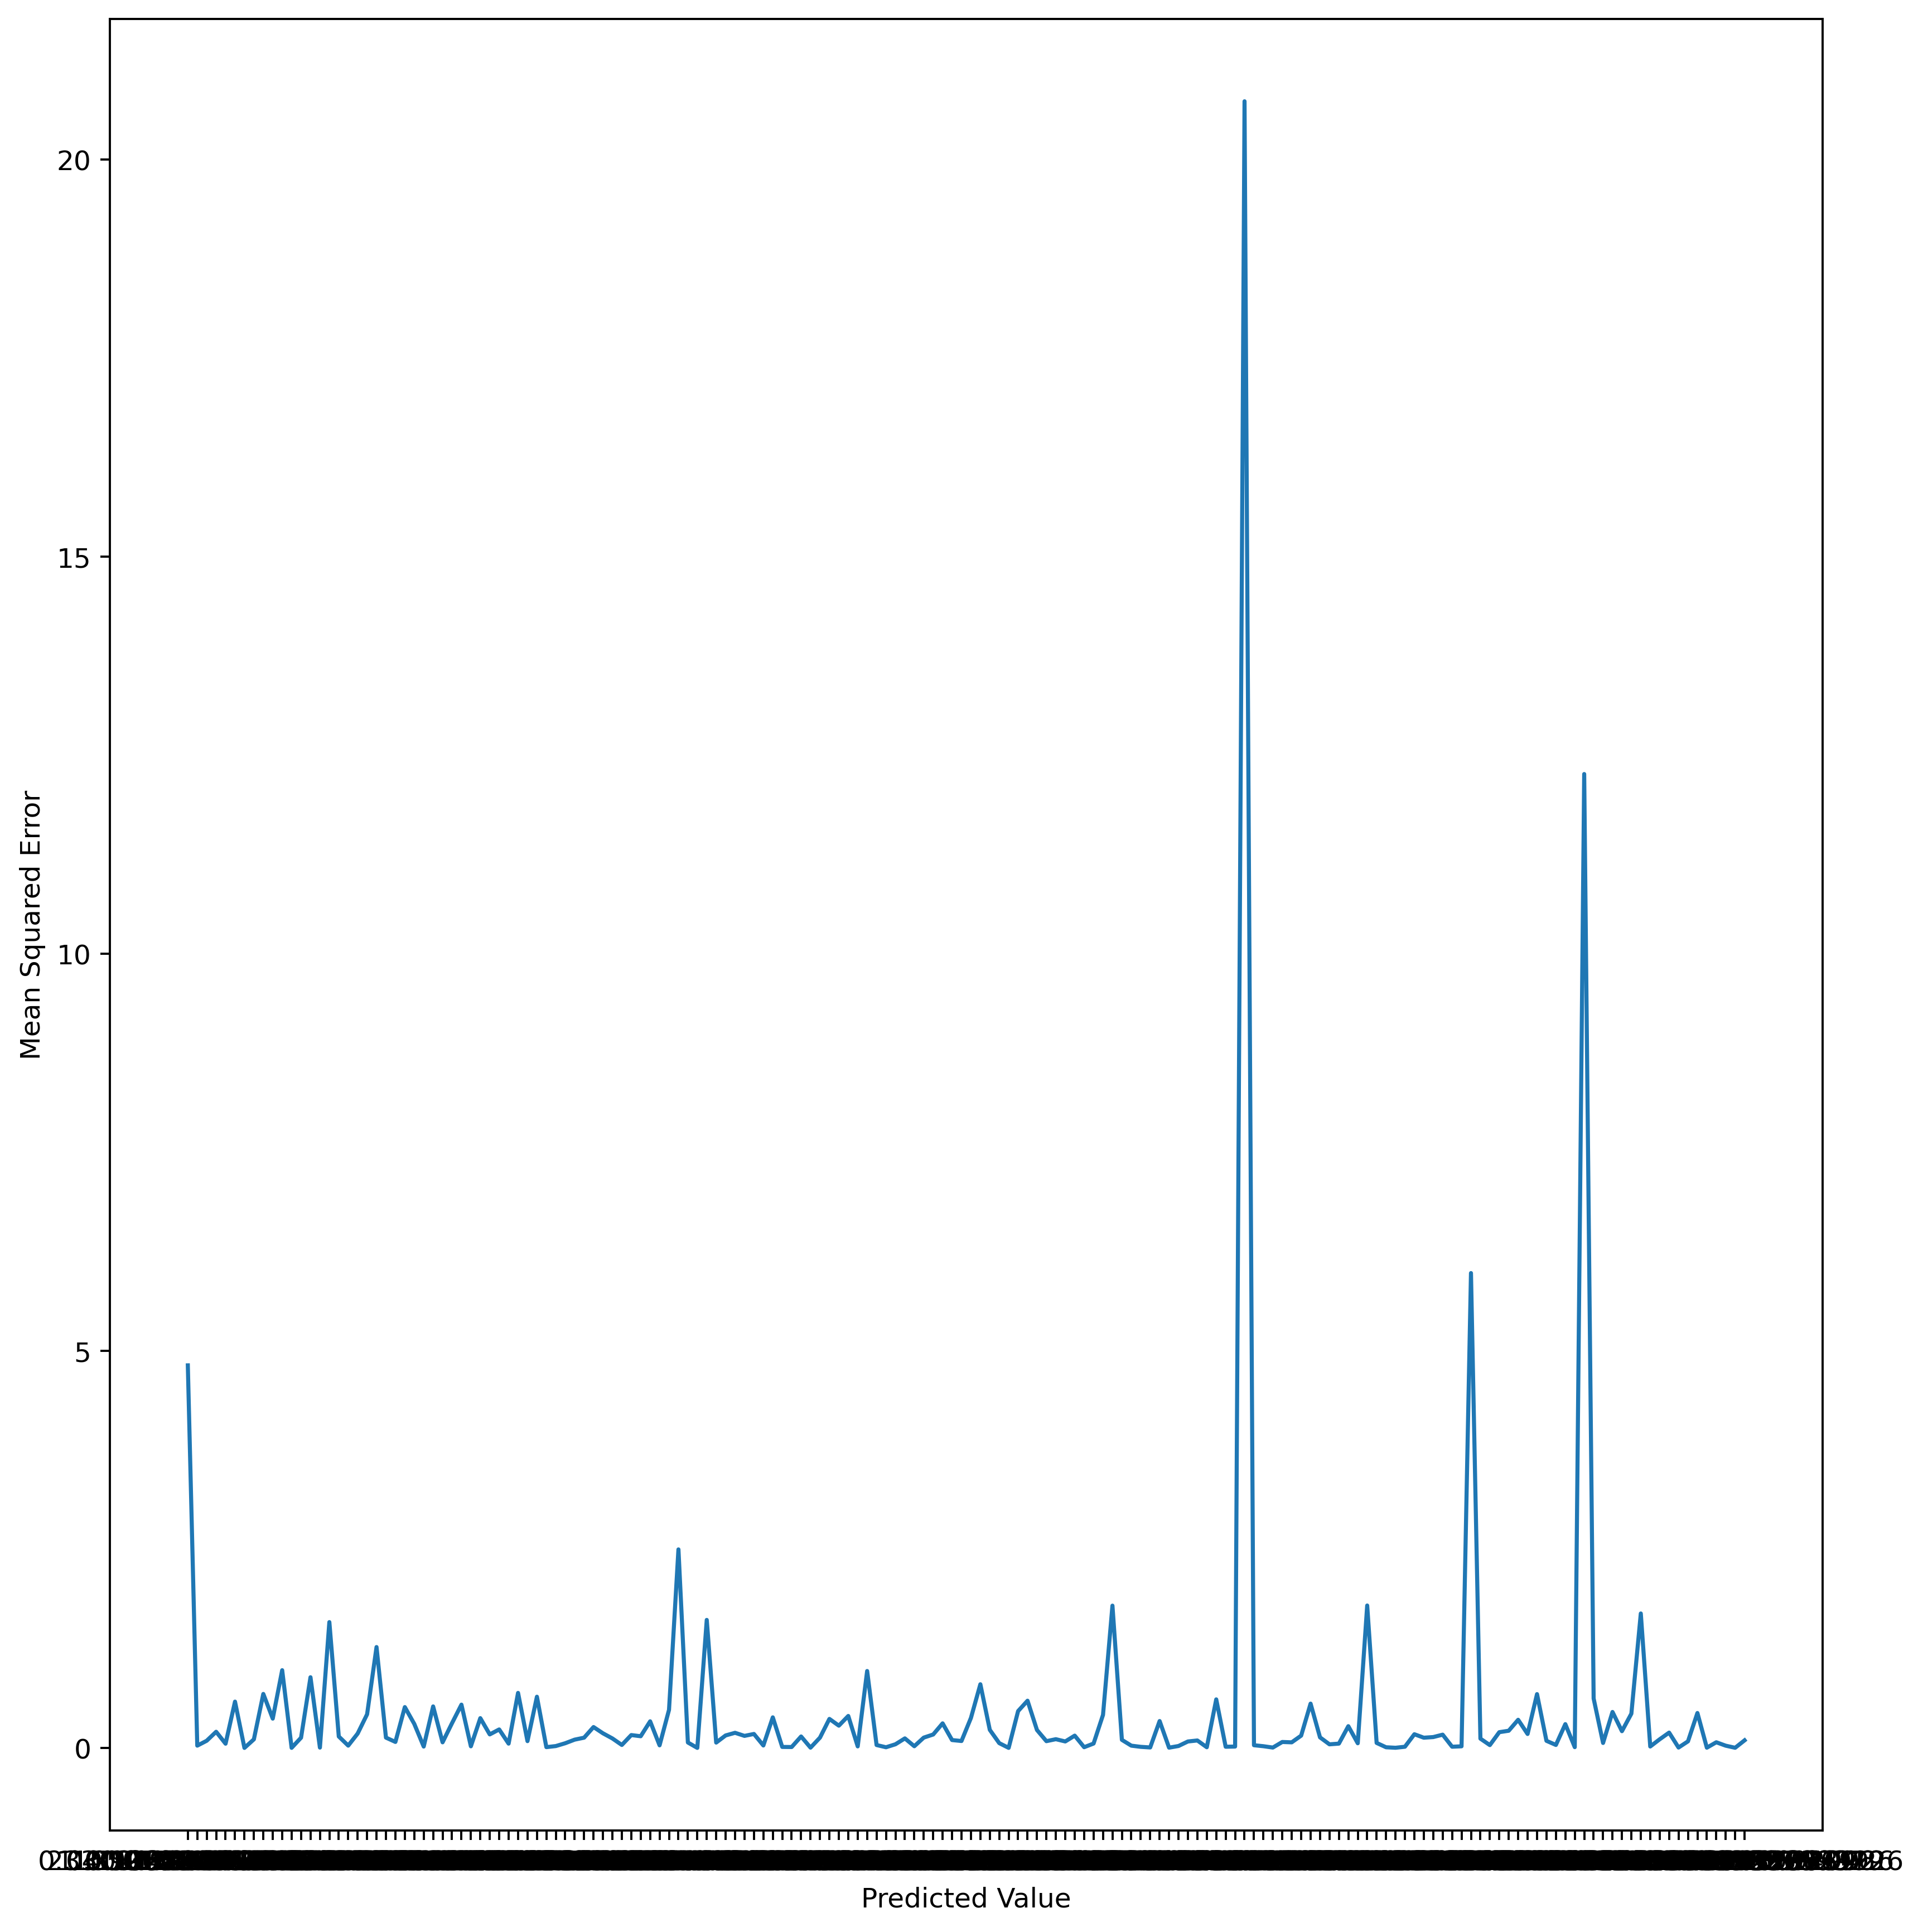

Mean squared error:
2.266747259318026


In [7]:
predictions_data_rf = rf_most_important.predict(X[:, important_indices])
small_pred = list()
small_y = list()
    
small_errors = list()
for i in range(len(y)):
    if i % 100 == 0:      
        # calculate error
        err = (y[i] - predictions_data_rf[i])**2
        # store error
        small_pred.append(predictions_data_rf[i])
        small_y.append(y[i])
        small_errors.append(err)
        # report error
        if i % 1000 == 0:
            print('>%.1f, %.1f = %.3f' % (y[i], predictions_data_rf[i], err))
# plot errors
print("number of taken elems for MSE is " + str(len(small_errors)))

fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True) 
plt.plot(small_errors)
plt.xticks(ticks=[i for i in range(len(small_errors))], labels=small_pred)
plt.xlabel('Predicted Value')
plt.ylabel('Mean Squared Error')
plt.show()

print("Mean squared error:")
print(metrics.mean_squared_error(y, predictions_data_rf))

### 3.2.4. Root MSE

In RMSE we are not changing the loss function and the solution is still the same. We just reduce the order and can see mistakes better by taking the root.

>4.3, 2.1 = 2.195
>1.4, 0.5 = 0.989
>1.7, 0.5 = 1.127
>0.5, 0.6 = 0.142
>0.2, 0.5 = 0.242
>0.1, 0.2 = 0.180
>0.0, 0.5 = 0.419
>0.0, 0.7 = 0.634
>0.1, 0.6 = 0.556
>0.2, 0.7 = 0.475
>0.6, 0.4 = 0.168
>0.0, 0.2 = 0.120
>0.1, 0.4 = 0.364
>0.1, 0.6 = 0.415
>0.1, 0.6 = 0.465
>0.3, 0.5 = 0.250
>0.8, 0.2 = 0.663
number of taken elems for MSE is 166


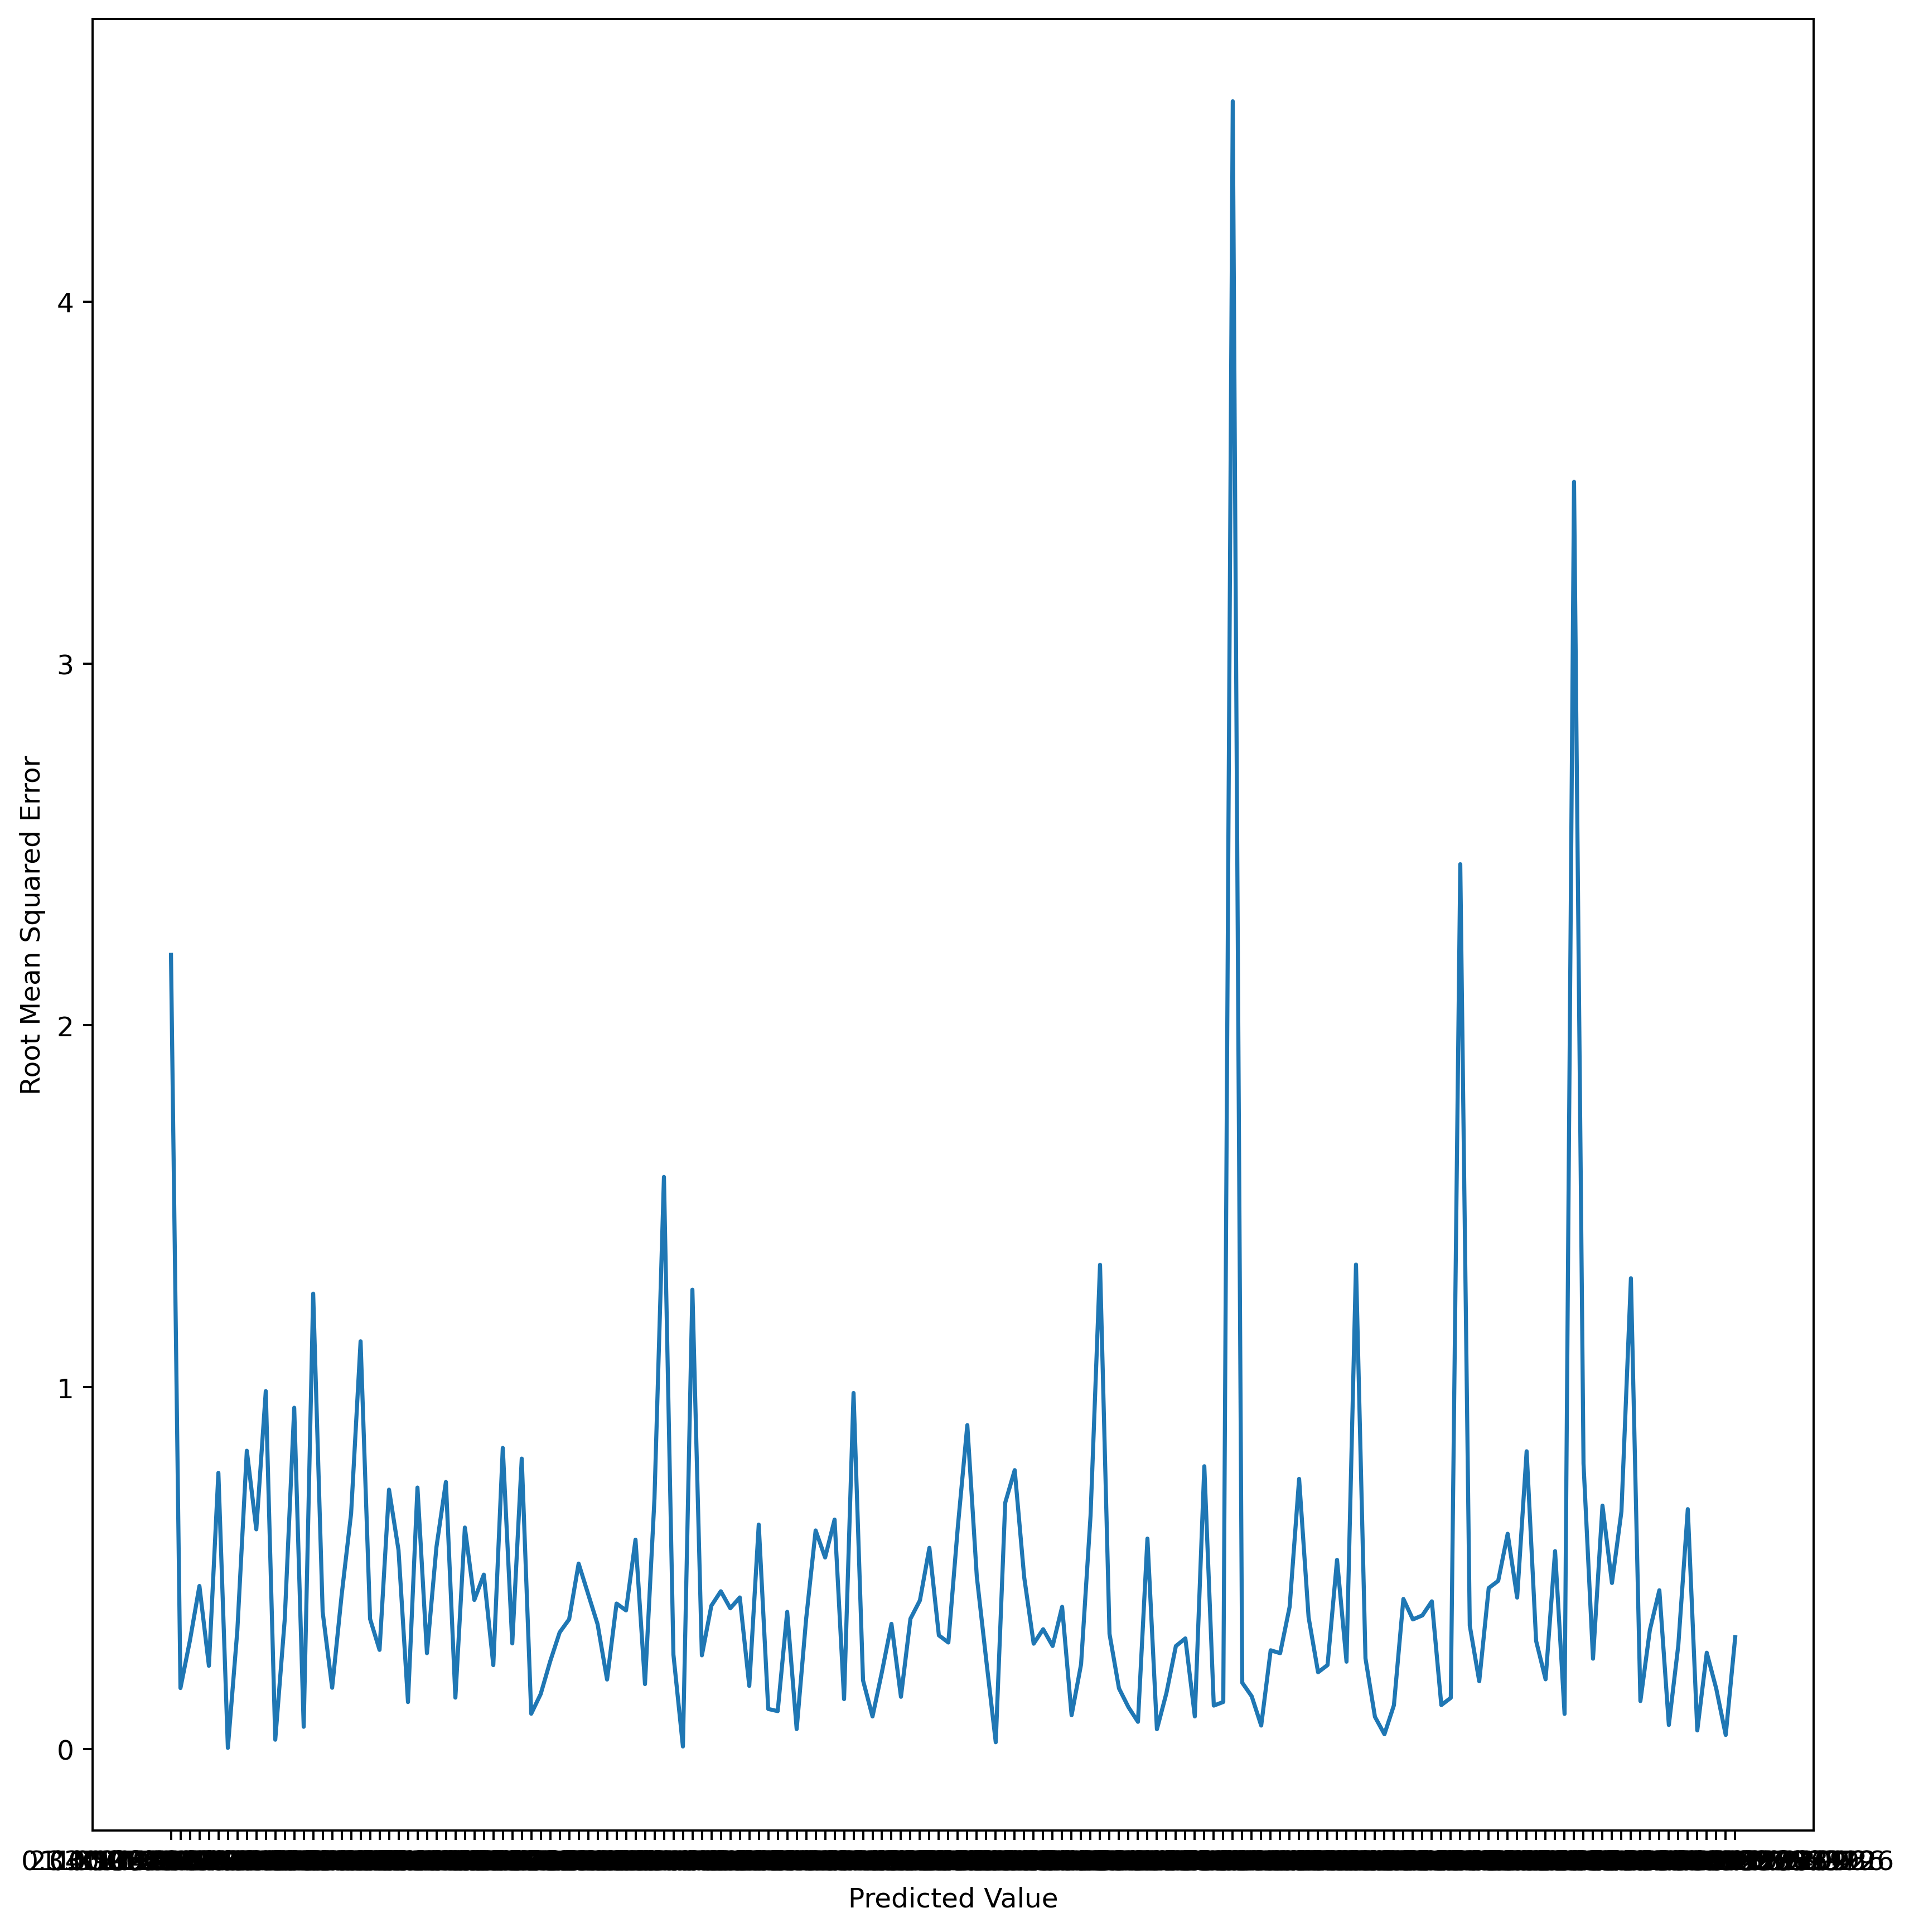

Mean absolute error:
1.5055720704496434


In [8]:
small_pred = list()
small_y = list()
    
small_errors = list()
for i in range(len(y)):
    if i % 100 == 0:      
        # calculate error
        err = math.sqrt((y[i] - predictions_data_rf[i])**2)
        # store error
        small_pred.append(predictions_data_rf[i])
        small_y.append(y[i])
        small_errors.append(err)
        # report error
        if i % 1000 == 0:
            print('>%.1f, %.1f = %.3f' % (y[i], predictions_data_rf[i], err))
# plot errors
print("number of taken elems for MSE is " + str(len(small_errors)))

fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True) 
plt.plot(small_errors)
plt.xticks(ticks=[i for i in range(len(small_errors))], labels=small_pred)
plt.xlabel('Predicted Value')
plt.ylabel('Root Mean Squared Error')
plt.show()

print("Mean absolute error:")
print(math.sqrt(metrics.mean_squared_error(y, predictions_data_rf)))

### 3.2.5. Absolute error

Absolute error allows us to see how badly miscalculated prediction is in absolute values.

>4.3, 2.1 = 2.195
>1.4, 0.5 = 0.989
>1.7, 0.5 = 1.127
>0.5, 0.6 = 0.142
>0.2, 0.5 = 0.242
>0.1, 0.2 = 0.180
>0.0, 0.5 = 0.419
>0.0, 0.7 = 0.634
>0.1, 0.6 = 0.556
>0.2, 0.7 = 0.475
>0.6, 0.4 = 0.168
>0.0, 0.2 = 0.120
>0.1, 0.4 = 0.364
>0.1, 0.6 = 0.415
>0.1, 0.6 = 0.465
>0.3, 0.5 = 0.250
>0.8, 0.2 = 0.663
number of taken elems for MSE is 166


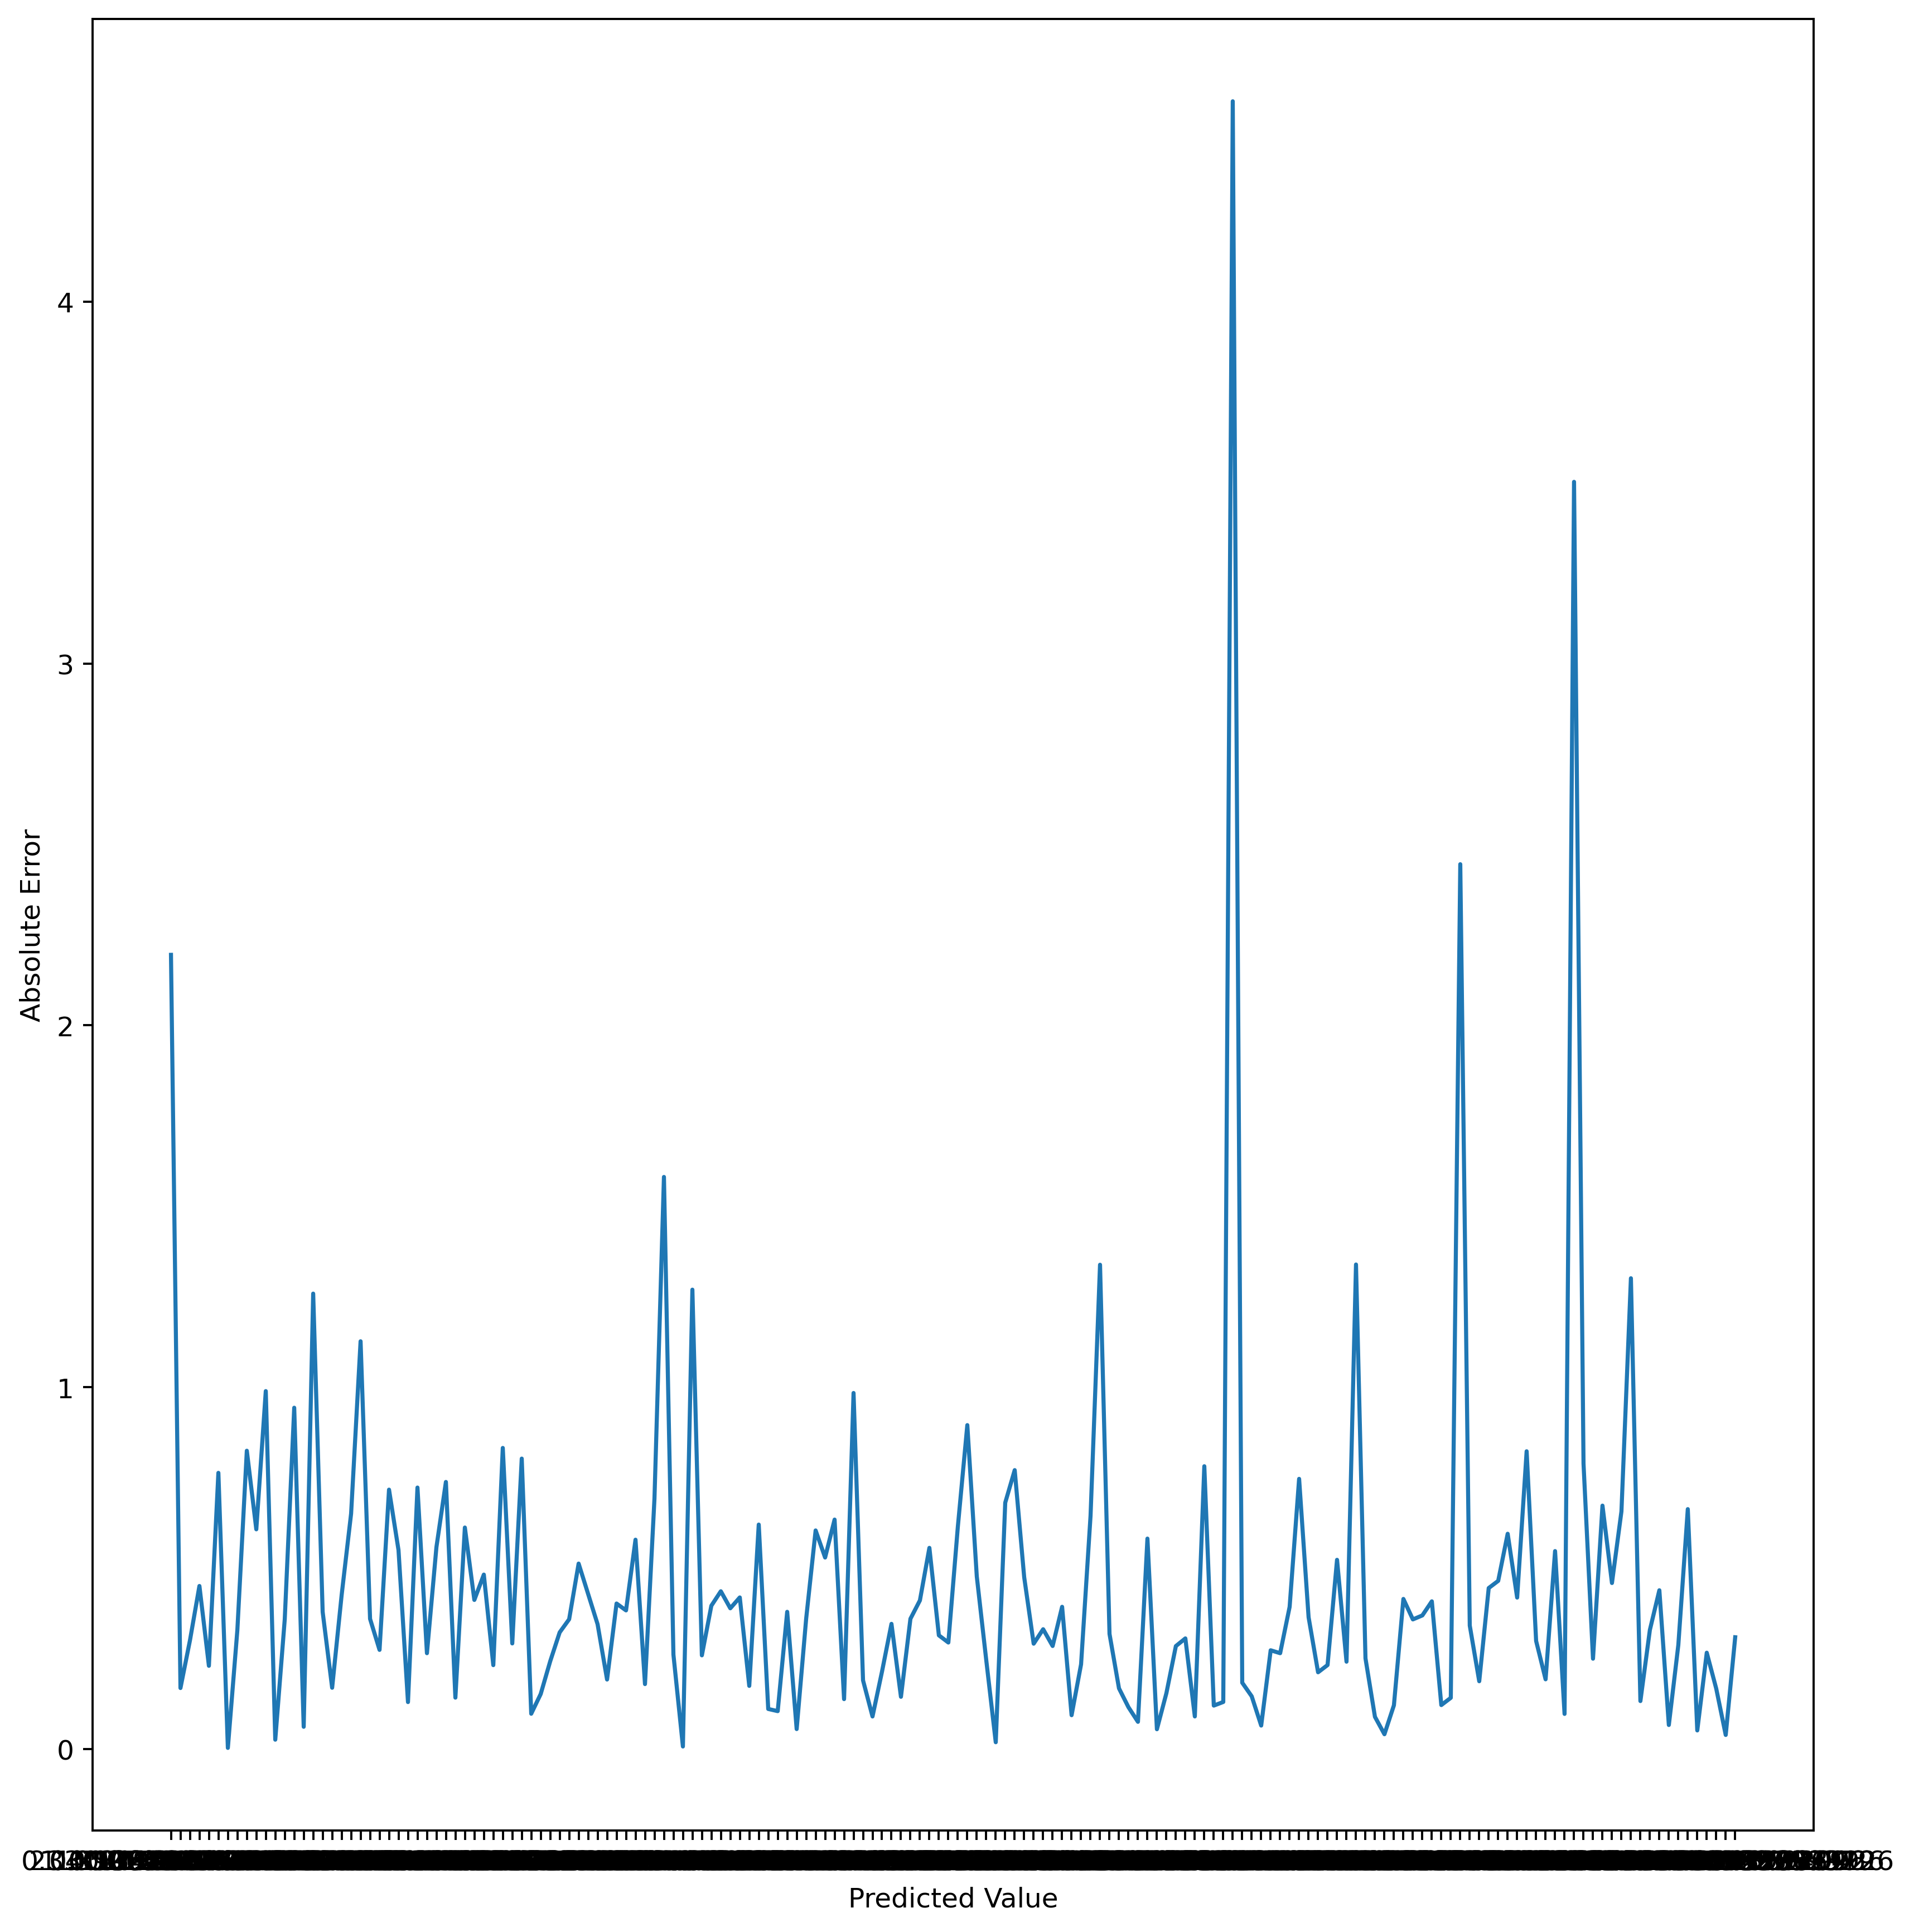

Mean absolute error:
0.5563061863912188


In [9]:
small_pred = list()
small_y = list()
    
small_errors = list()
for i in range(len(y)):
    if i % 100 == 0:      
        # calculate error
        err = abs(y[i] - predictions_data_rf[i])
        # store error
        small_pred.append(predictions_data_rf[i])
        small_y.append(y[i])
        small_errors.append(err)
        # report error
        if i % 1000 == 0:
            print('>%.1f, %.1f = %.3f' % (y[i], predictions_data_rf[i], err))
# plot errors
print("number of taken elems for MSE is " + str(len(small_errors)))

fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True) 
plt.plot(small_errors)
plt.xticks(ticks=[i for i in range(len(small_errors))], labels=small_pred)
plt.xlabel('Predicted Value')
plt.ylabel('Absolute Error')
plt.show()

print("Mean absolute error:")
print(metrics.mean_absolute_error(y, predictions_data_rf))

### 3.2.6. Coefficient of Determination

CoD for this technique and dataset says that the model is dependant on one attribute much more, than on the others and therefore we have dependent attributes.

In [10]:
print("Coefficient of determination of RFR on VGSales dataset is " + str(metrics.r2_score(y, predictions_data_rf)))

Coefficient of determination of RFR on VGSales dataset is 0.06253972224706517


Which is better then predicting mean values only and much better than having incorrect solutions everywhere(0 and 2 consequently). The best imaginary regressor has CoD equal to 1.

# 4. Gradient Boosting Regressor
## 4.1. Implementation

Here we use library module for regressor of Gradient Boosting, also based on the attributes importance we make better prediction.

Variable: publishers           Importance: 0.77
Variable: years                Importance: 0.09
Variable: platforms            Importance: 0.07
Variable: genres               Importance: 0.07


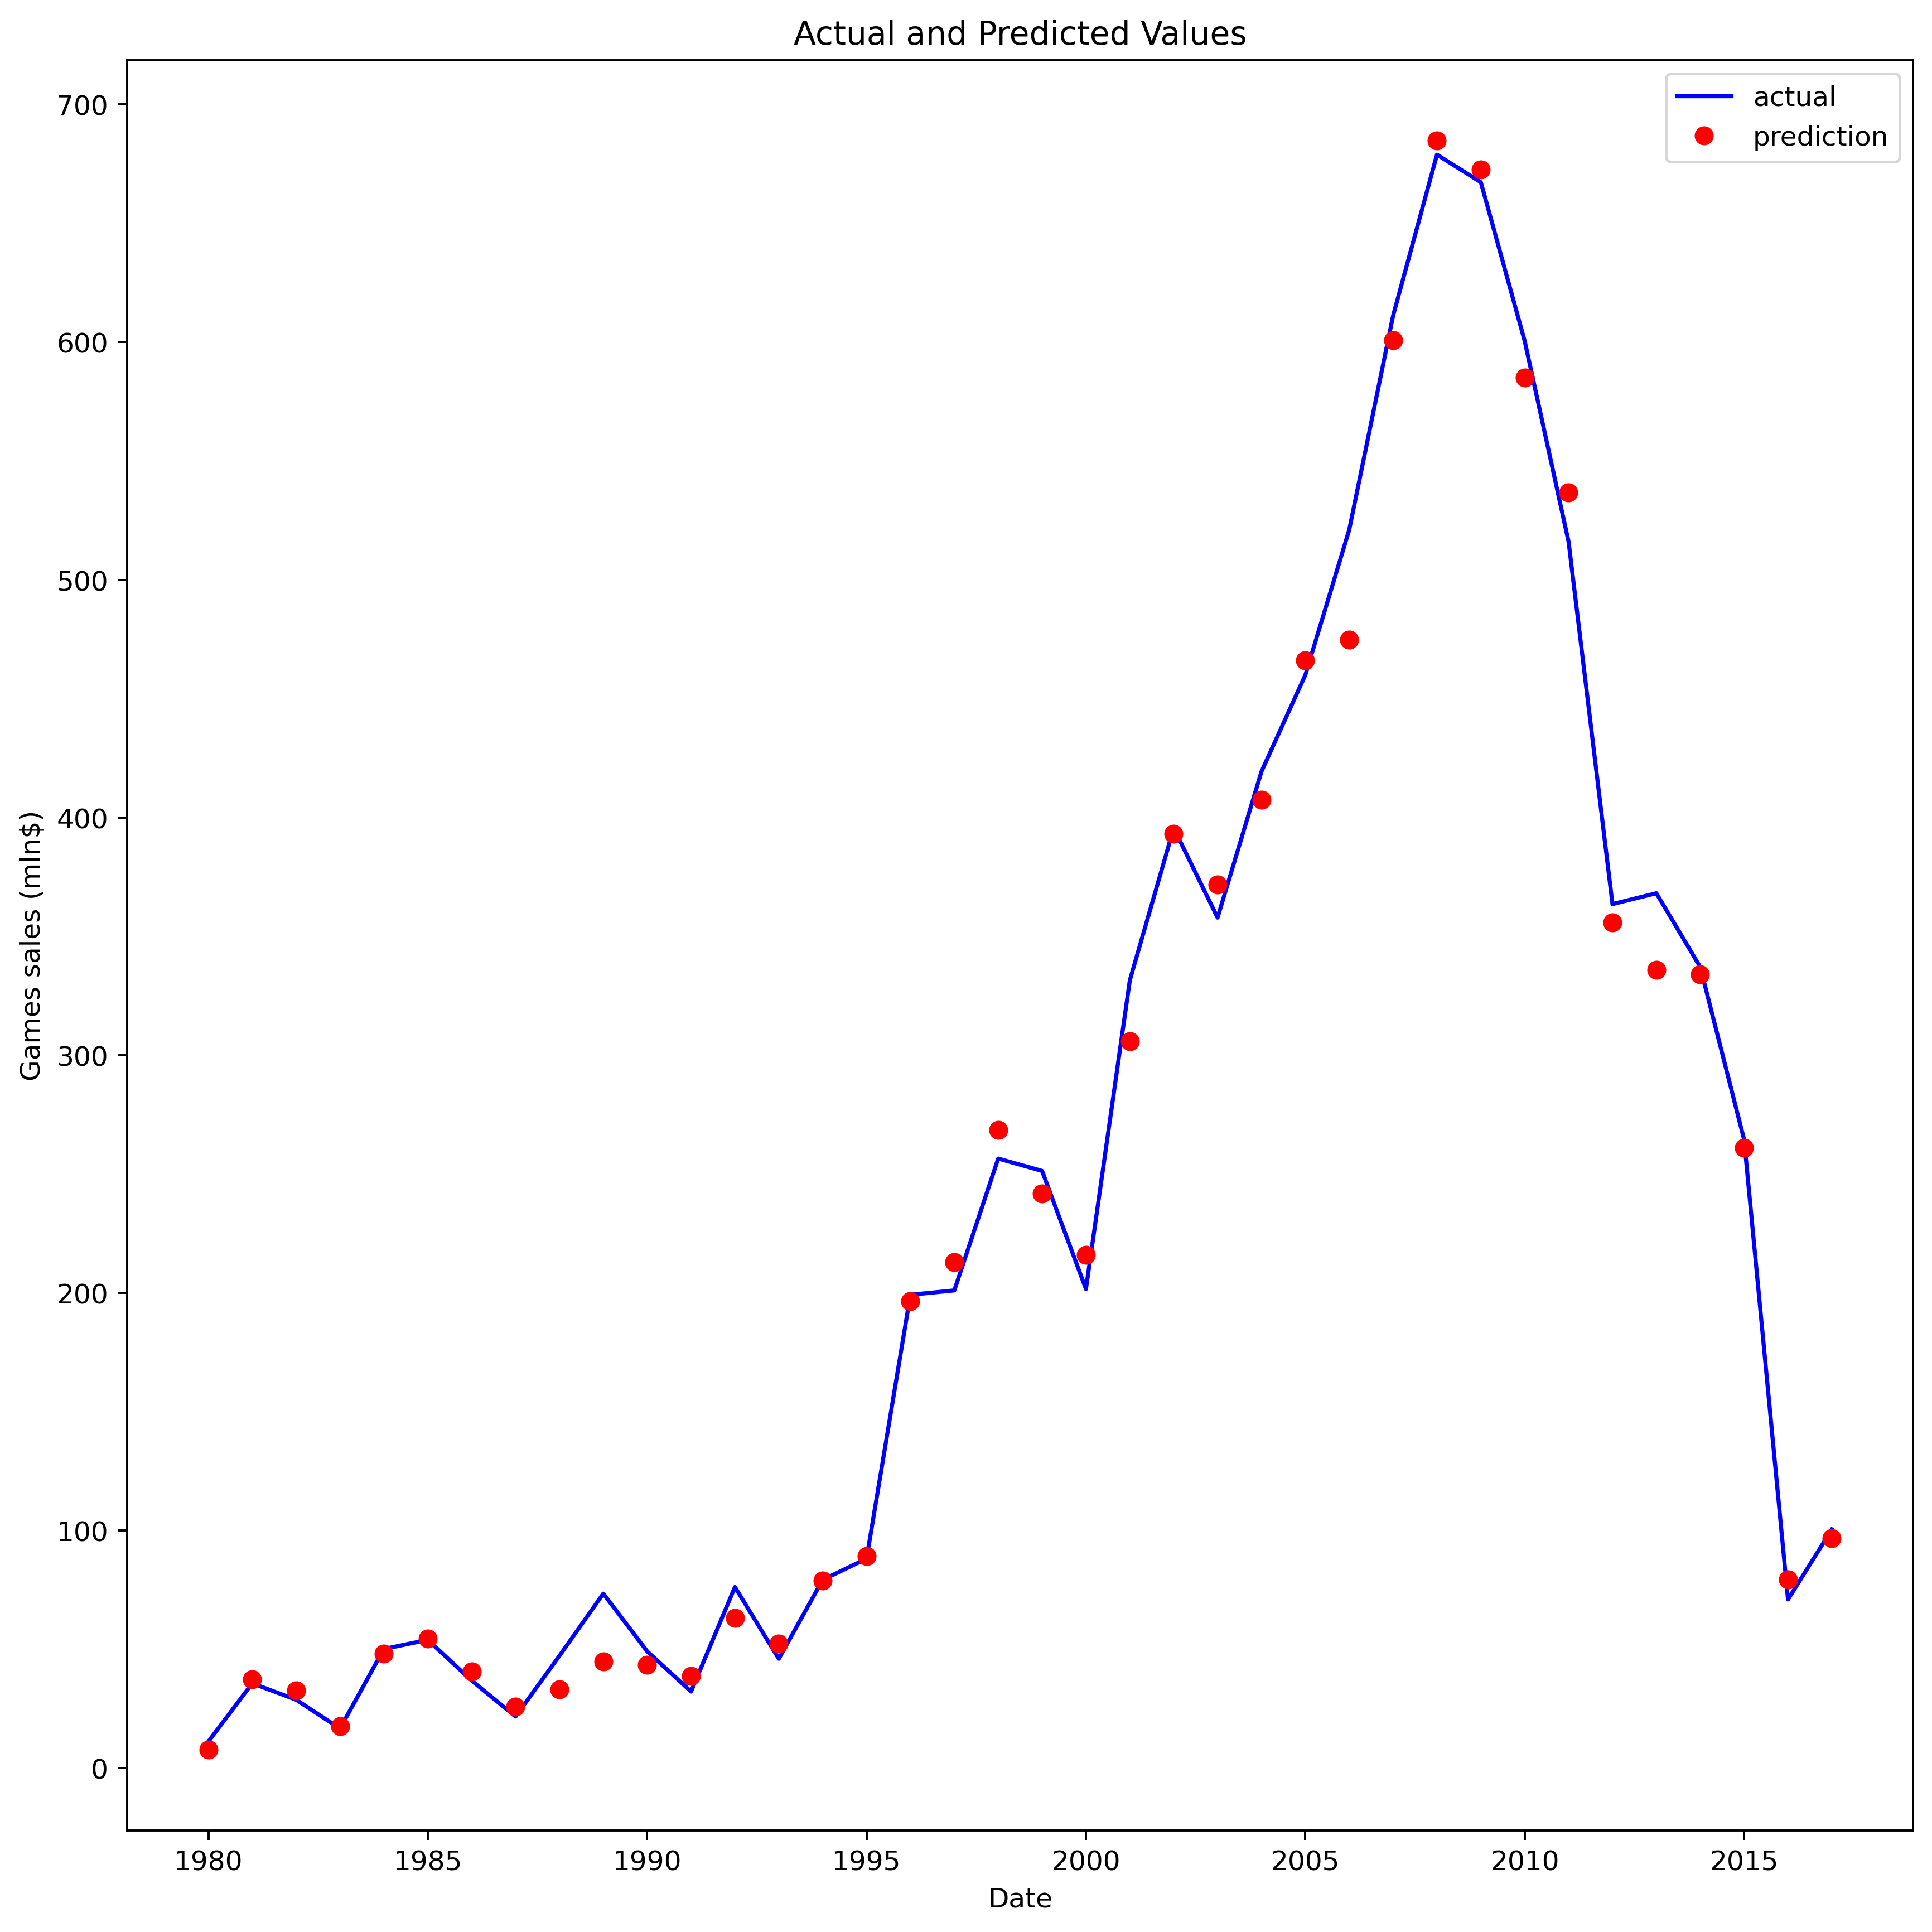

In [12]:
#new

# function to get unique values
def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list
     


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.17, random_state = 42)
regr = GradientBoostingRegressor(n_estimators = 1000, max_depth = 3,min_samples_split = 5, learning_rate = 0.001, loss = 'ls')
regr.fit(X_train, y_train)
    
# Get numerical feature importances
importances = list(regr.feature_importances_)
# List of tuples with variable and importance
feature_list = ['platforms', 'years', 'genres', 'publishers']
feature_importances_gb = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances_gb = sorted(feature_importances_gb, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_gb];



# New random forest with only the two most important variables
gb_most_important = GradientBoostingRegressor(n_estimators = 16000,max_features = 2,max_depth = 3,min_samples_split = 5, learning_rate = 0.001, loss = 'ls')
# Extract the two most important features
important_indices = [feature_list.index('genres'), feature_list.index('years')]
train_important = X_train[:, important_indices]
test_important = X_test[:, important_indices]
# Train the random forest
gb_most_important.fit(train_important, y_train)


predictions_data_gb = gb_most_important.predict(X[:, important_indices])



yrs  = unique(years)
sum_by_years_actual_gb = []
sum_by_years_pred_gb = []
for i in yrs:
    indices = [k for k, x in enumerate(years) if x == i]
    sum_by_years_actual_gb.append(np.sum(y[indices[0]:indices[len(indices) - 1]]))
    sum_by_years_pred_gb.append(np.sum(predictions_data_gb[indices[0]:indices[len(indices) - 1]]))
    
    
fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True)    
plt.plot(yrs, sum_by_years_actual_gb, 'b-', label = 'actual')
plt.plot(yrs, sum_by_years_pred_gb, 'ro', label = 'prediction')
plt.legend()
plt.xlabel('Date'); plt.ylabel('Games sales (mln$)'); plt.title('Actual and Predicted Values');

## 4.2. Description

### 4.2.1 Residual plot

The points in a residual plot are not randomly dispersed around the horizontal axis, thus making it applicable for our model.

Text(0.5, 1.0, 'Residual plot')

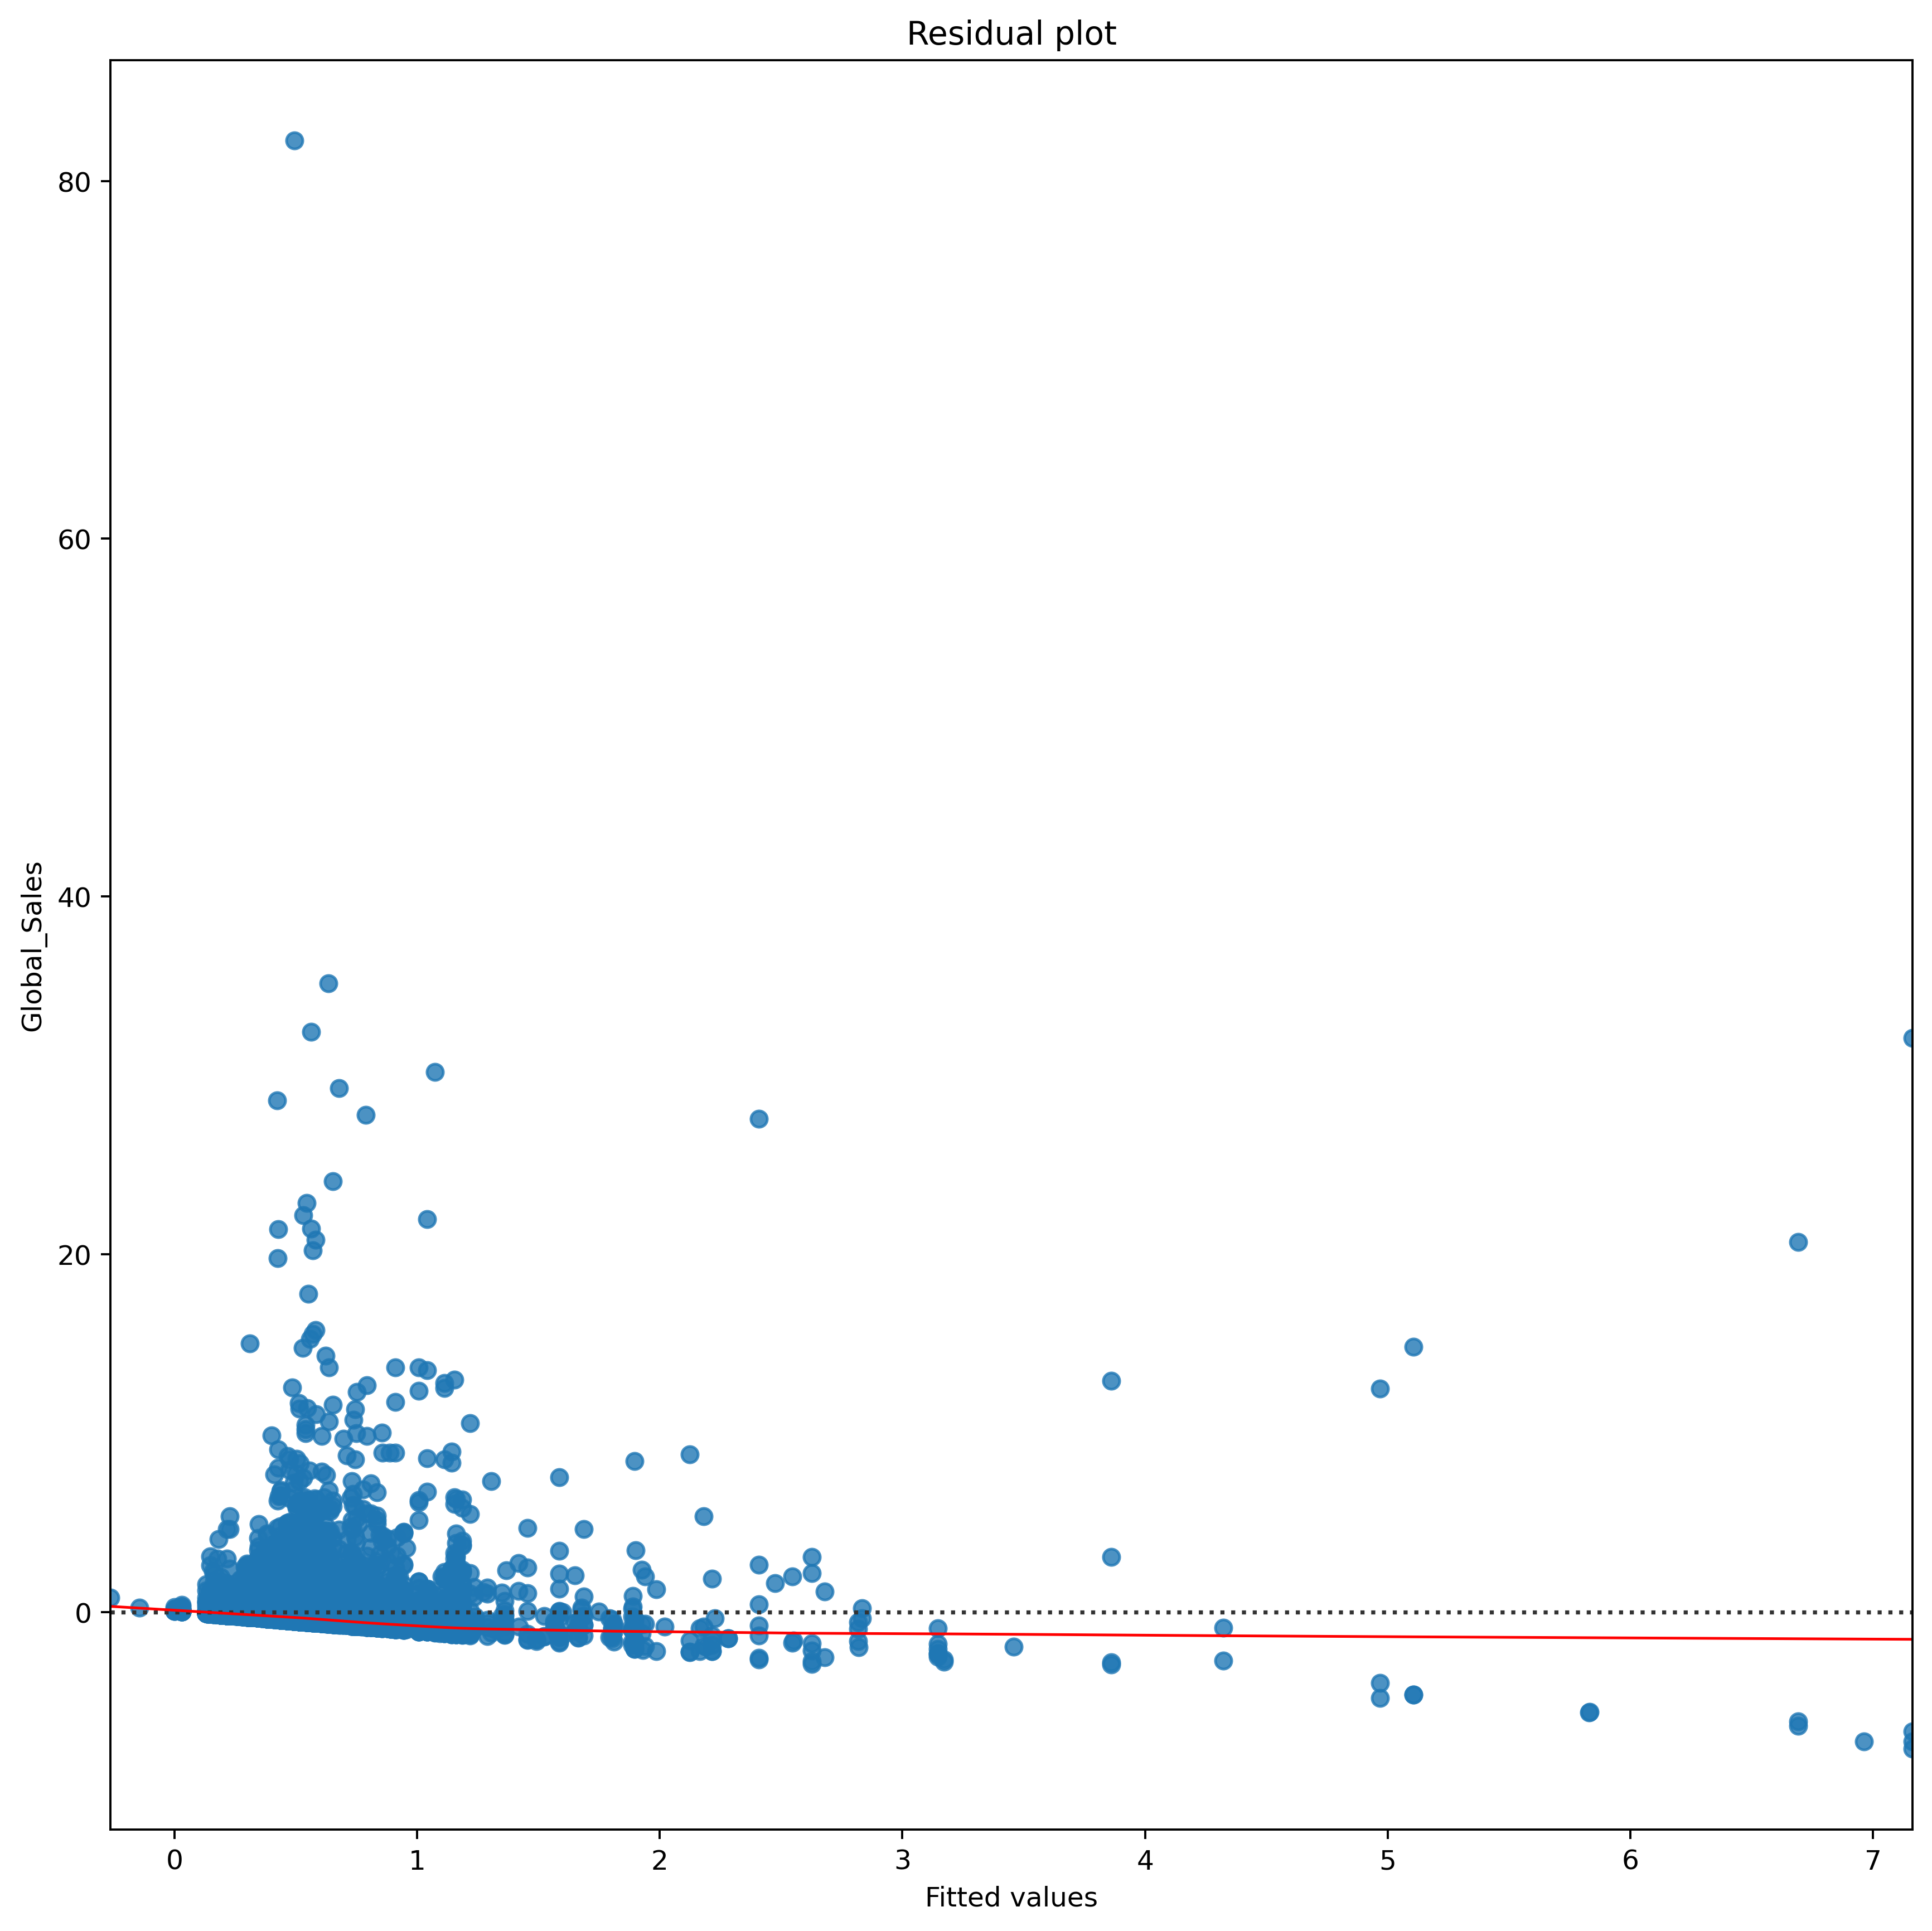

In [13]:
fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True)  
sn.residplot(x=predictions_data_gb, y='Global_Sales', data=vgsales, lowess=True, dropna=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

### 4.2.2. Normal QQ Plot

If the prediction is correct, the points should fall approximately along this reference line.

Text(0.5, 1.0, 'Normal Q-Q Plot')

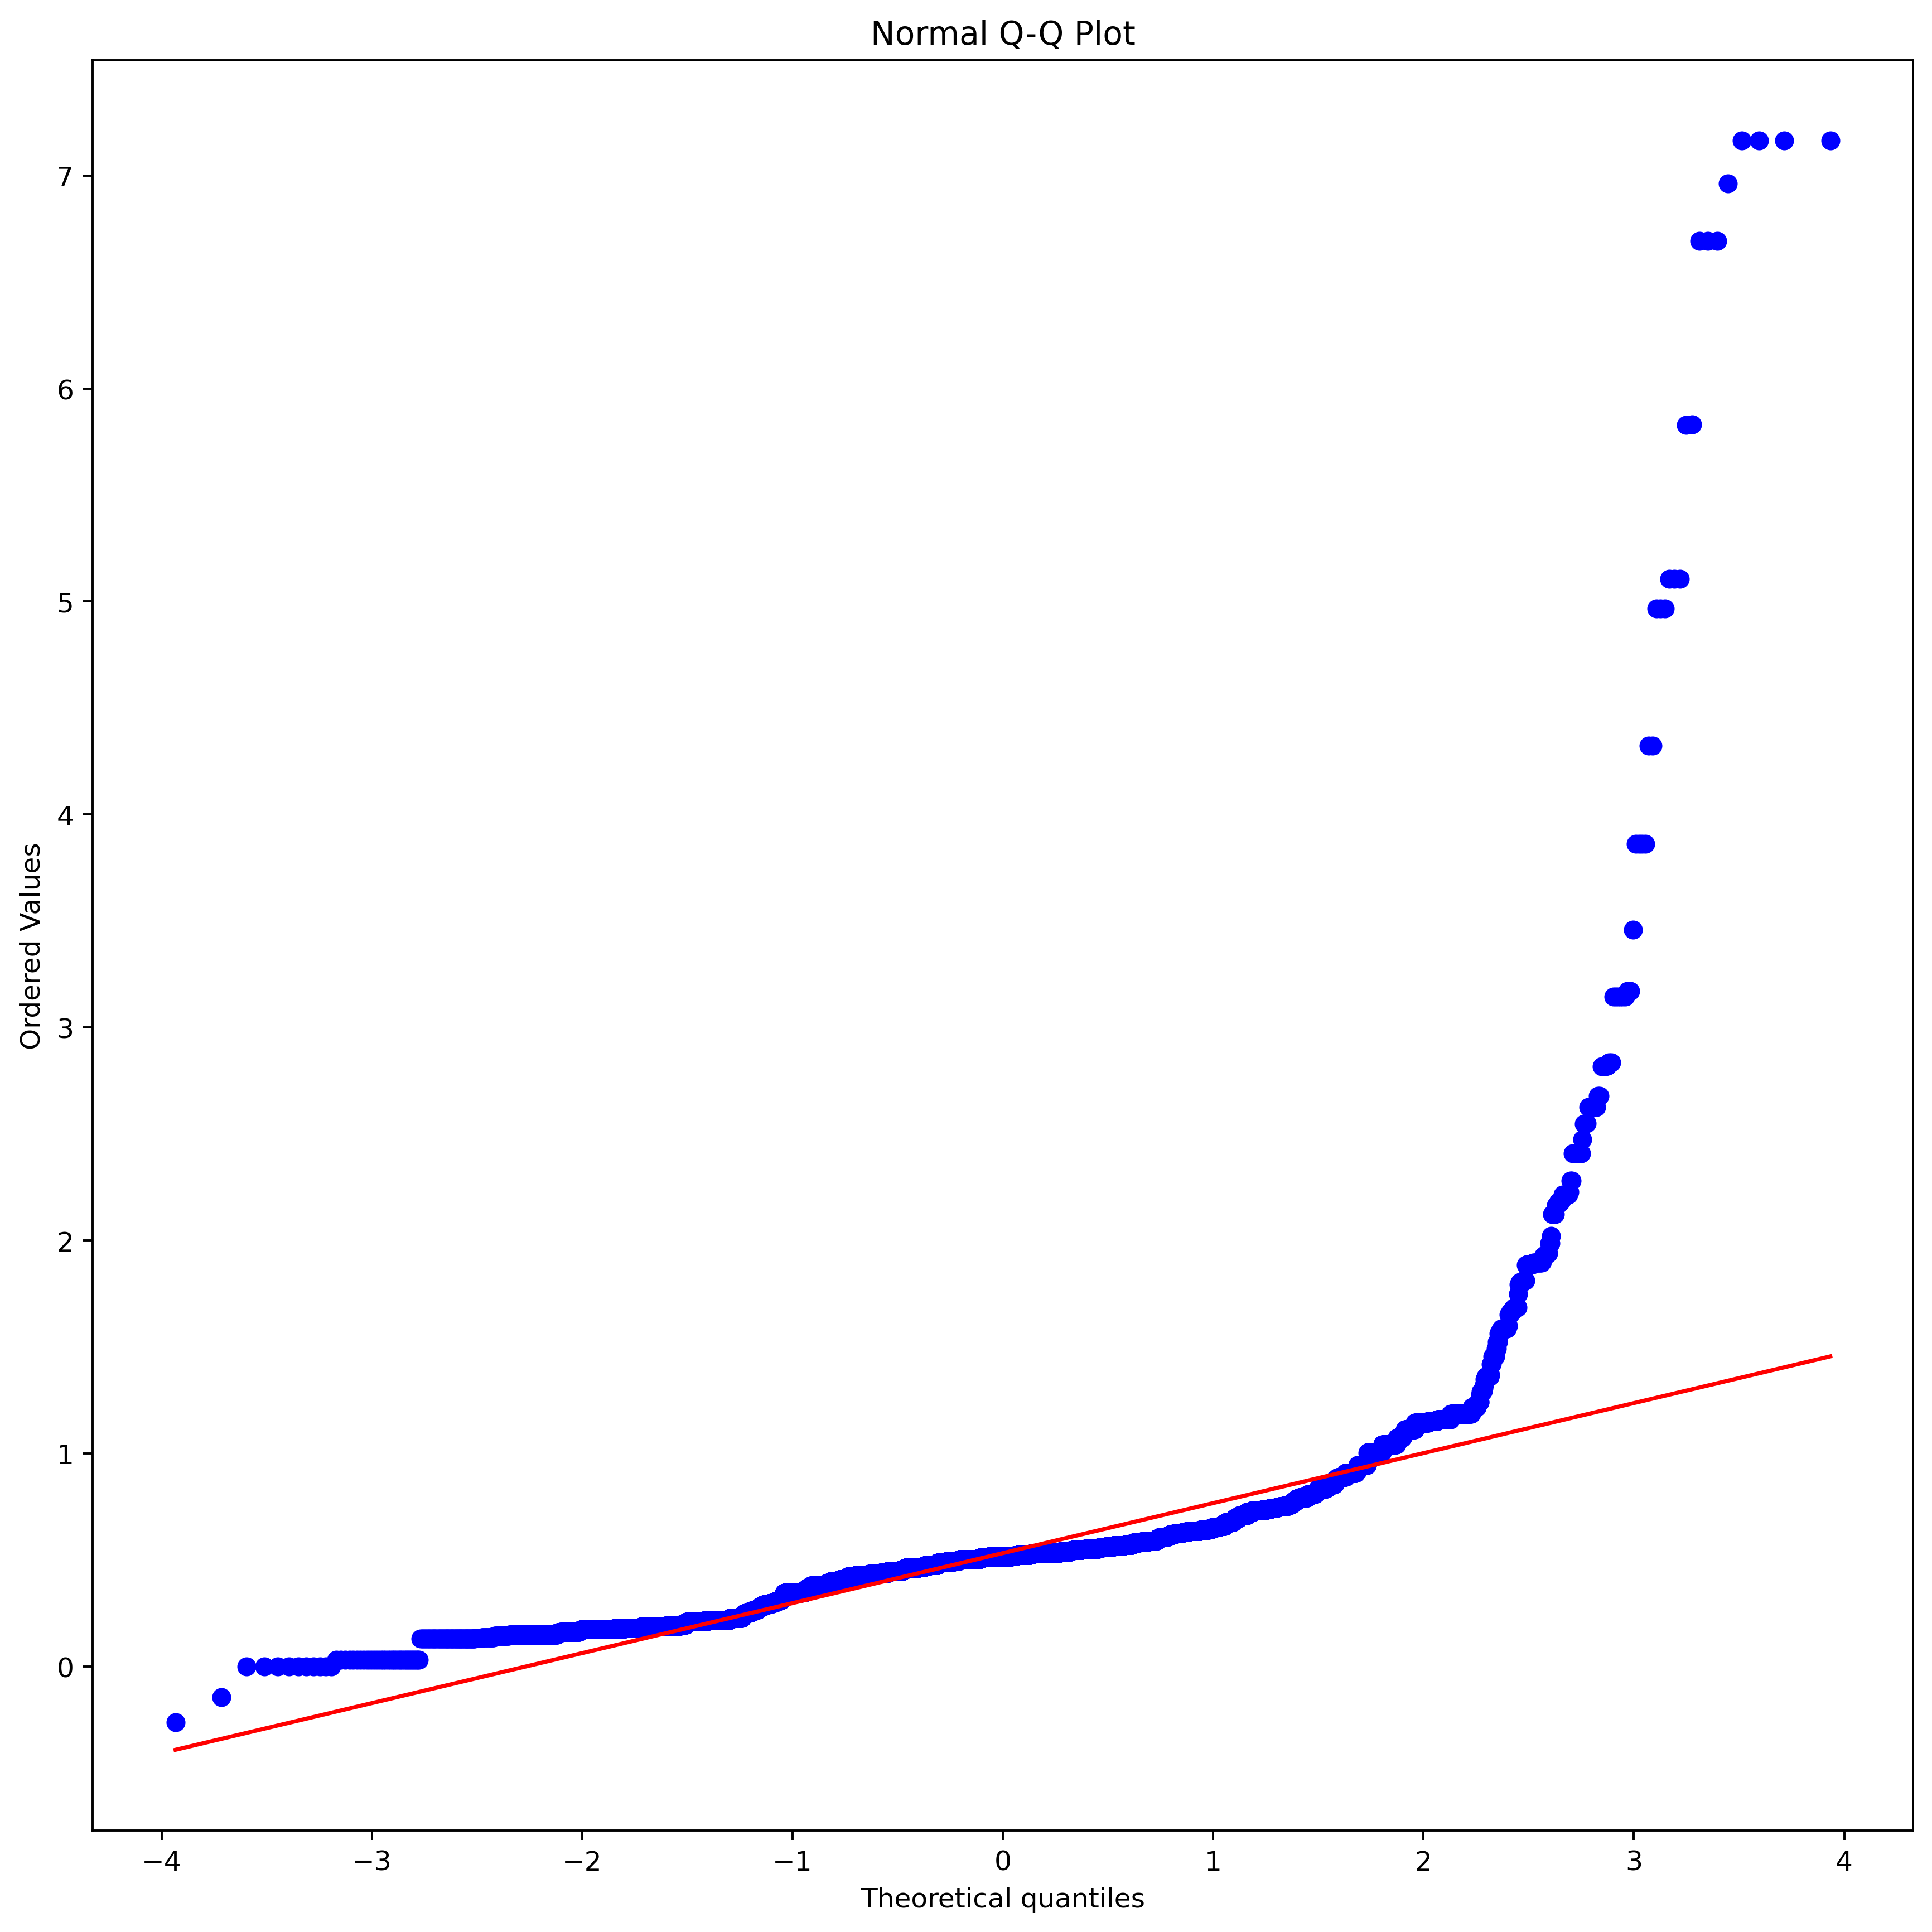

In [15]:

fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True)  
stats.probplot(predictions_data_gb, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

### 4.2.3. Mean Squared Error

We can see that it is quiet low and it is good. Over the time of fitting and training, MSE is constantly decreasing and the final result is comparable with the other method.

>4.3, 1.4 = 8.357
>1.4, 0.6 = 0.676
>1.7, 0.5 = 1.331
>0.5, 0.6 = 0.012
>0.2, 0.5 = 0.087
>0.1, 0.2 = 0.032
>0.0, 0.5 = 0.204
>0.0, 0.4 = 0.163
>0.1, 0.5 = 0.231
>0.2, 0.5 = 0.129
>0.6, 0.6 = 0.000
>0.0, 0.2 = 0.025
>0.1, 0.4 = 0.121
>0.1, 0.7 = 0.372
>0.1, 0.6 = 0.292
>0.3, 0.5 = 0.066
>0.8, 0.2 = 0.422
number of taken elems for MSE is 166


<Figure size 3500x3500 with 0 Axes>

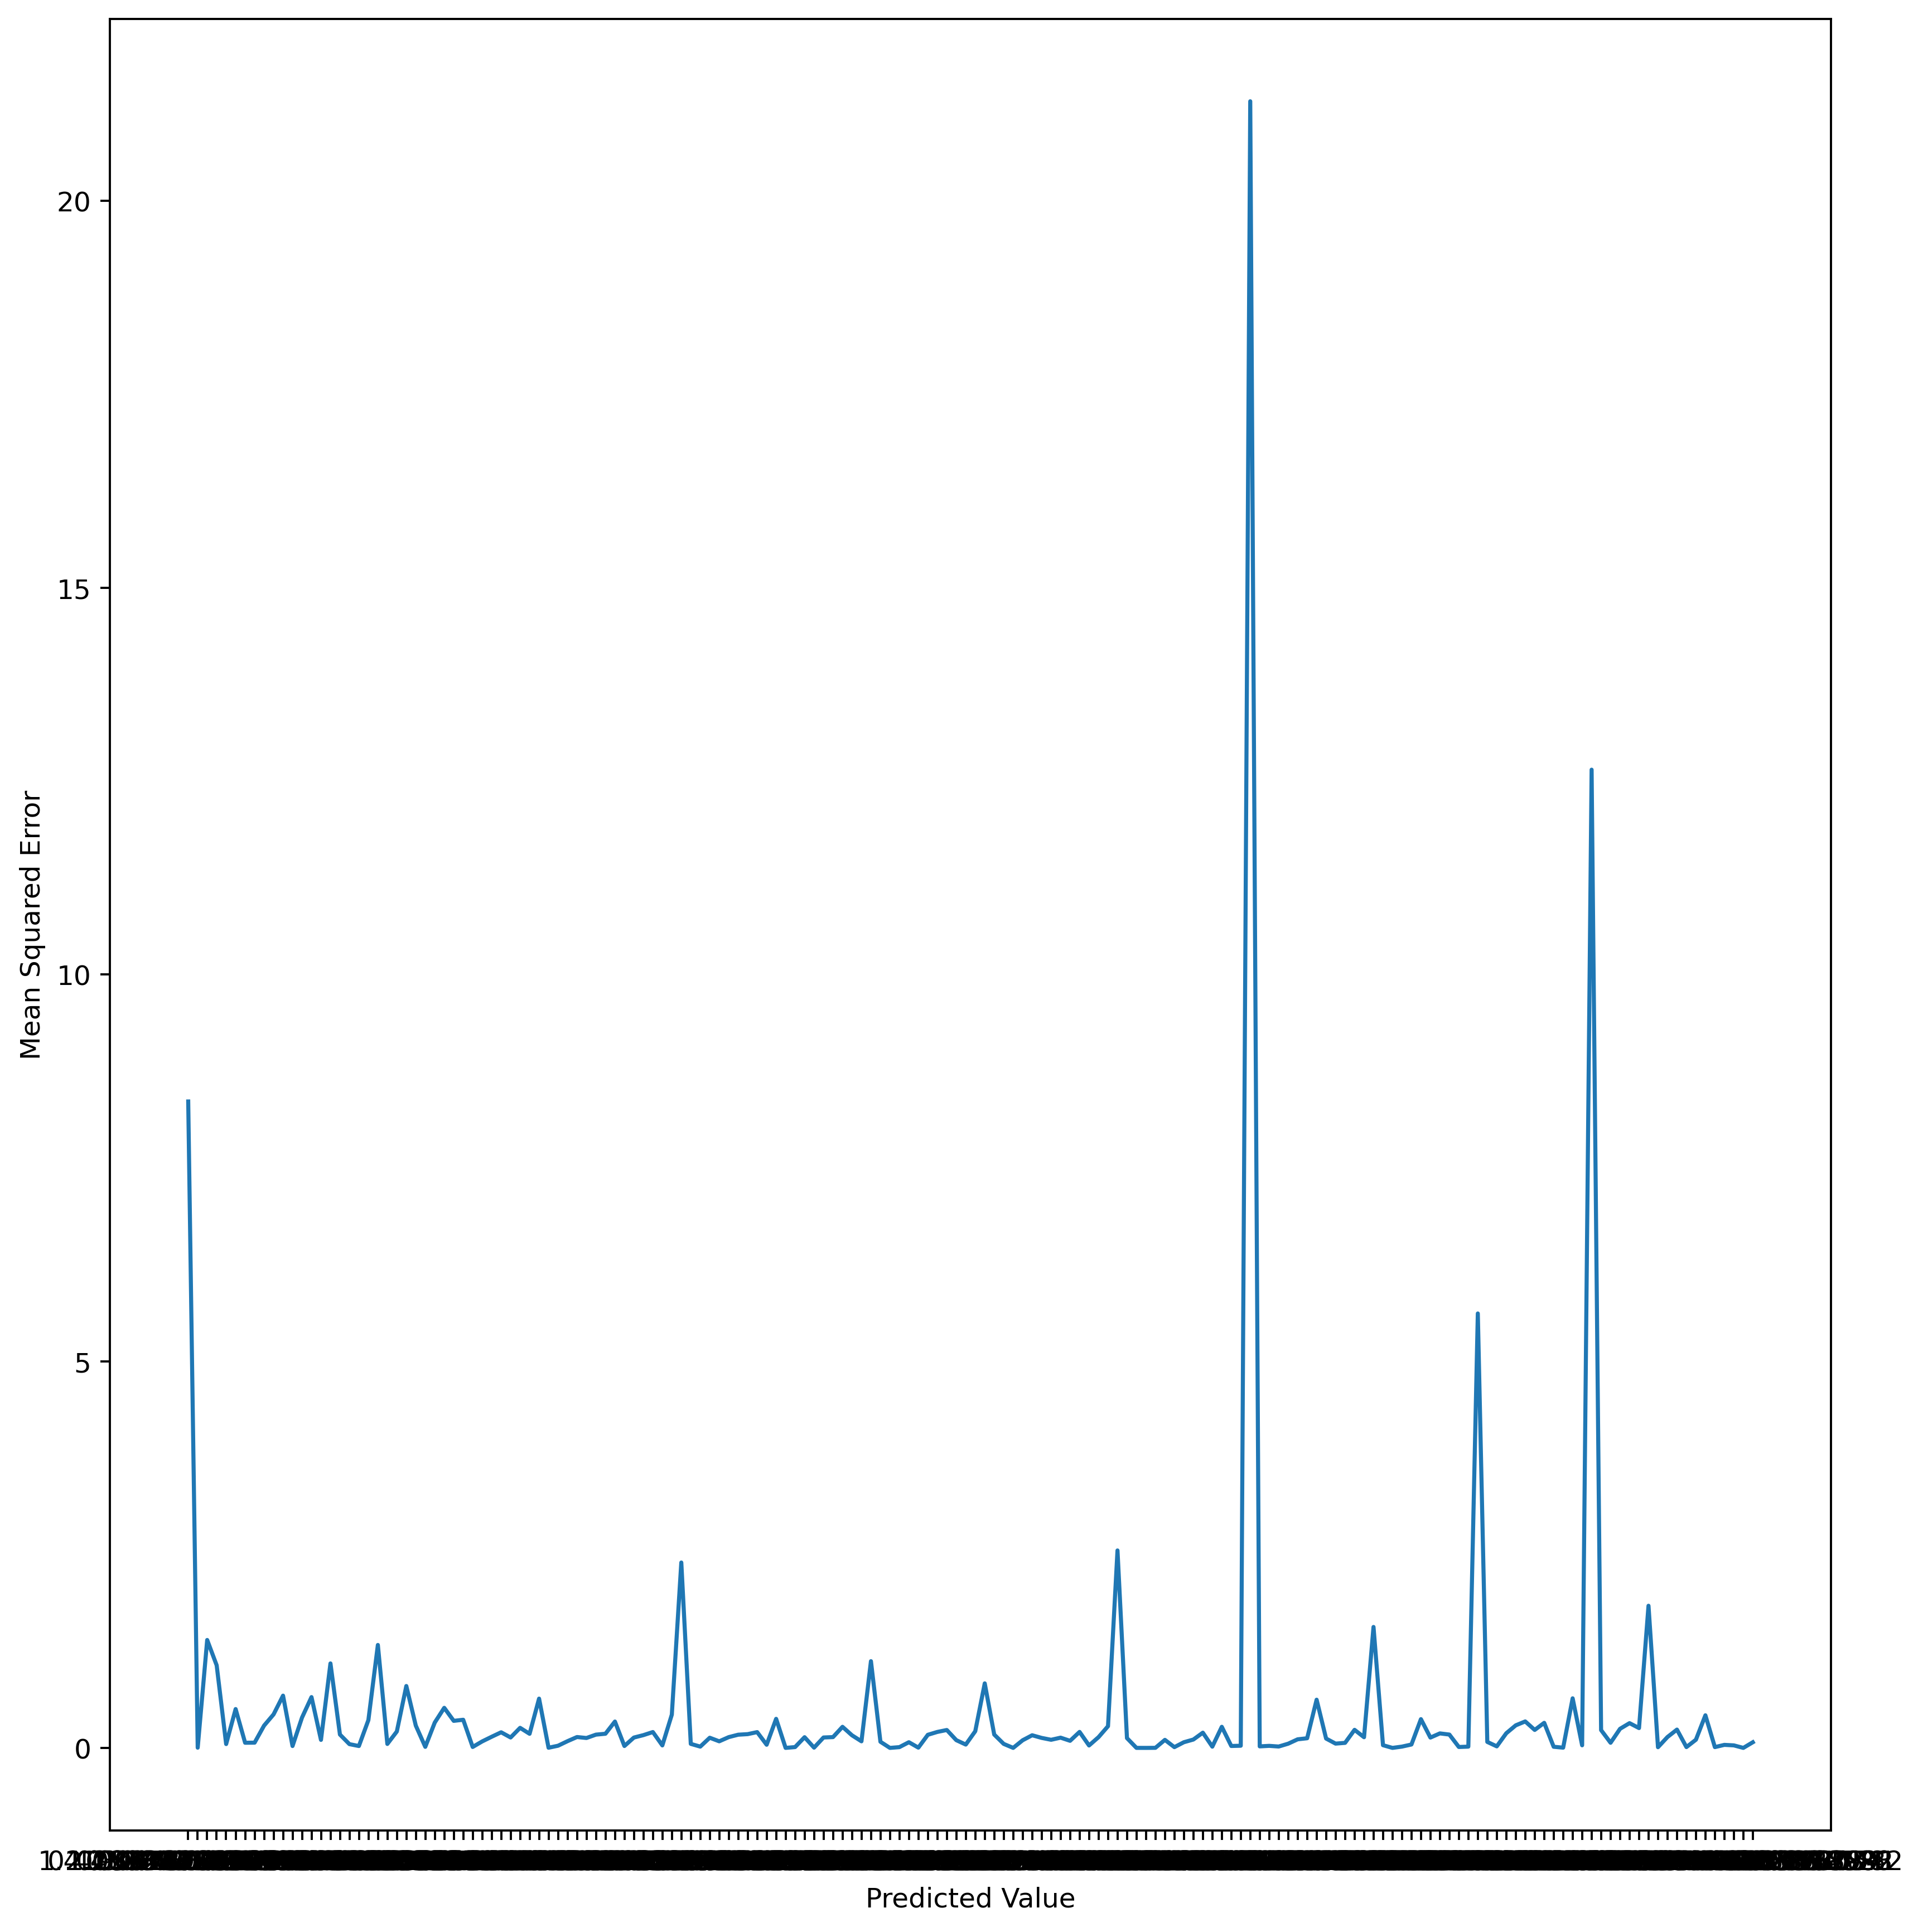

Mean squared error:
2.2962979096095237


In [16]:

fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True)  
small_pred = list()
small_y = list()
    
small_errors = list()
for i in range(len(y)):
    if i % 100 == 0:      
        # calculate error
        err = (y[i] - predictions_data_gb[i])**2
        # store error
        small_pred.append(predictions_data_gb[i])
        small_y.append(y[i])
        small_errors.append(err)
        # report error
        if i % 1000 == 0:
            print('>%.1f, %.1f = %.3f' % (y[i], predictions_data_gb[i], err))
# plot errors
print("number of taken elems for MSE is " + str(len(small_errors)))

fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True)  
plt.plot(small_errors)
plt.xticks(ticks=[i for i in range(len(small_errors))], labels=small_pred)
plt.xlabel('Predicted Value')
plt.ylabel('Mean Squared Error')
plt.show()

print("Mean squared error:")
print(metrics.mean_squared_error(y, predictions_data_gb))

### 4.2.4. Root MSE

In RMSE we are not changing the loss function and the solution is still the same. We just reduce the order and can see mistakes better by taking the root.

>4.3, 1.4 = 2.891
>1.4, 0.6 = 0.822
>1.7, 0.5 = 1.154
>0.5, 0.6 = 0.109
>0.2, 0.5 = 0.295
>0.1, 0.2 = 0.179
>0.0, 0.5 = 0.452
>0.0, 0.4 = 0.404
>0.1, 0.5 = 0.481
>0.2, 0.5 = 0.360
>0.6, 0.6 = 0.017
>0.0, 0.2 = 0.157
>0.1, 0.4 = 0.347
>0.1, 0.7 = 0.610
>0.1, 0.6 = 0.540
>0.3, 0.5 = 0.257
>0.8, 0.2 = 0.649
number of taken elems for MSE is 166


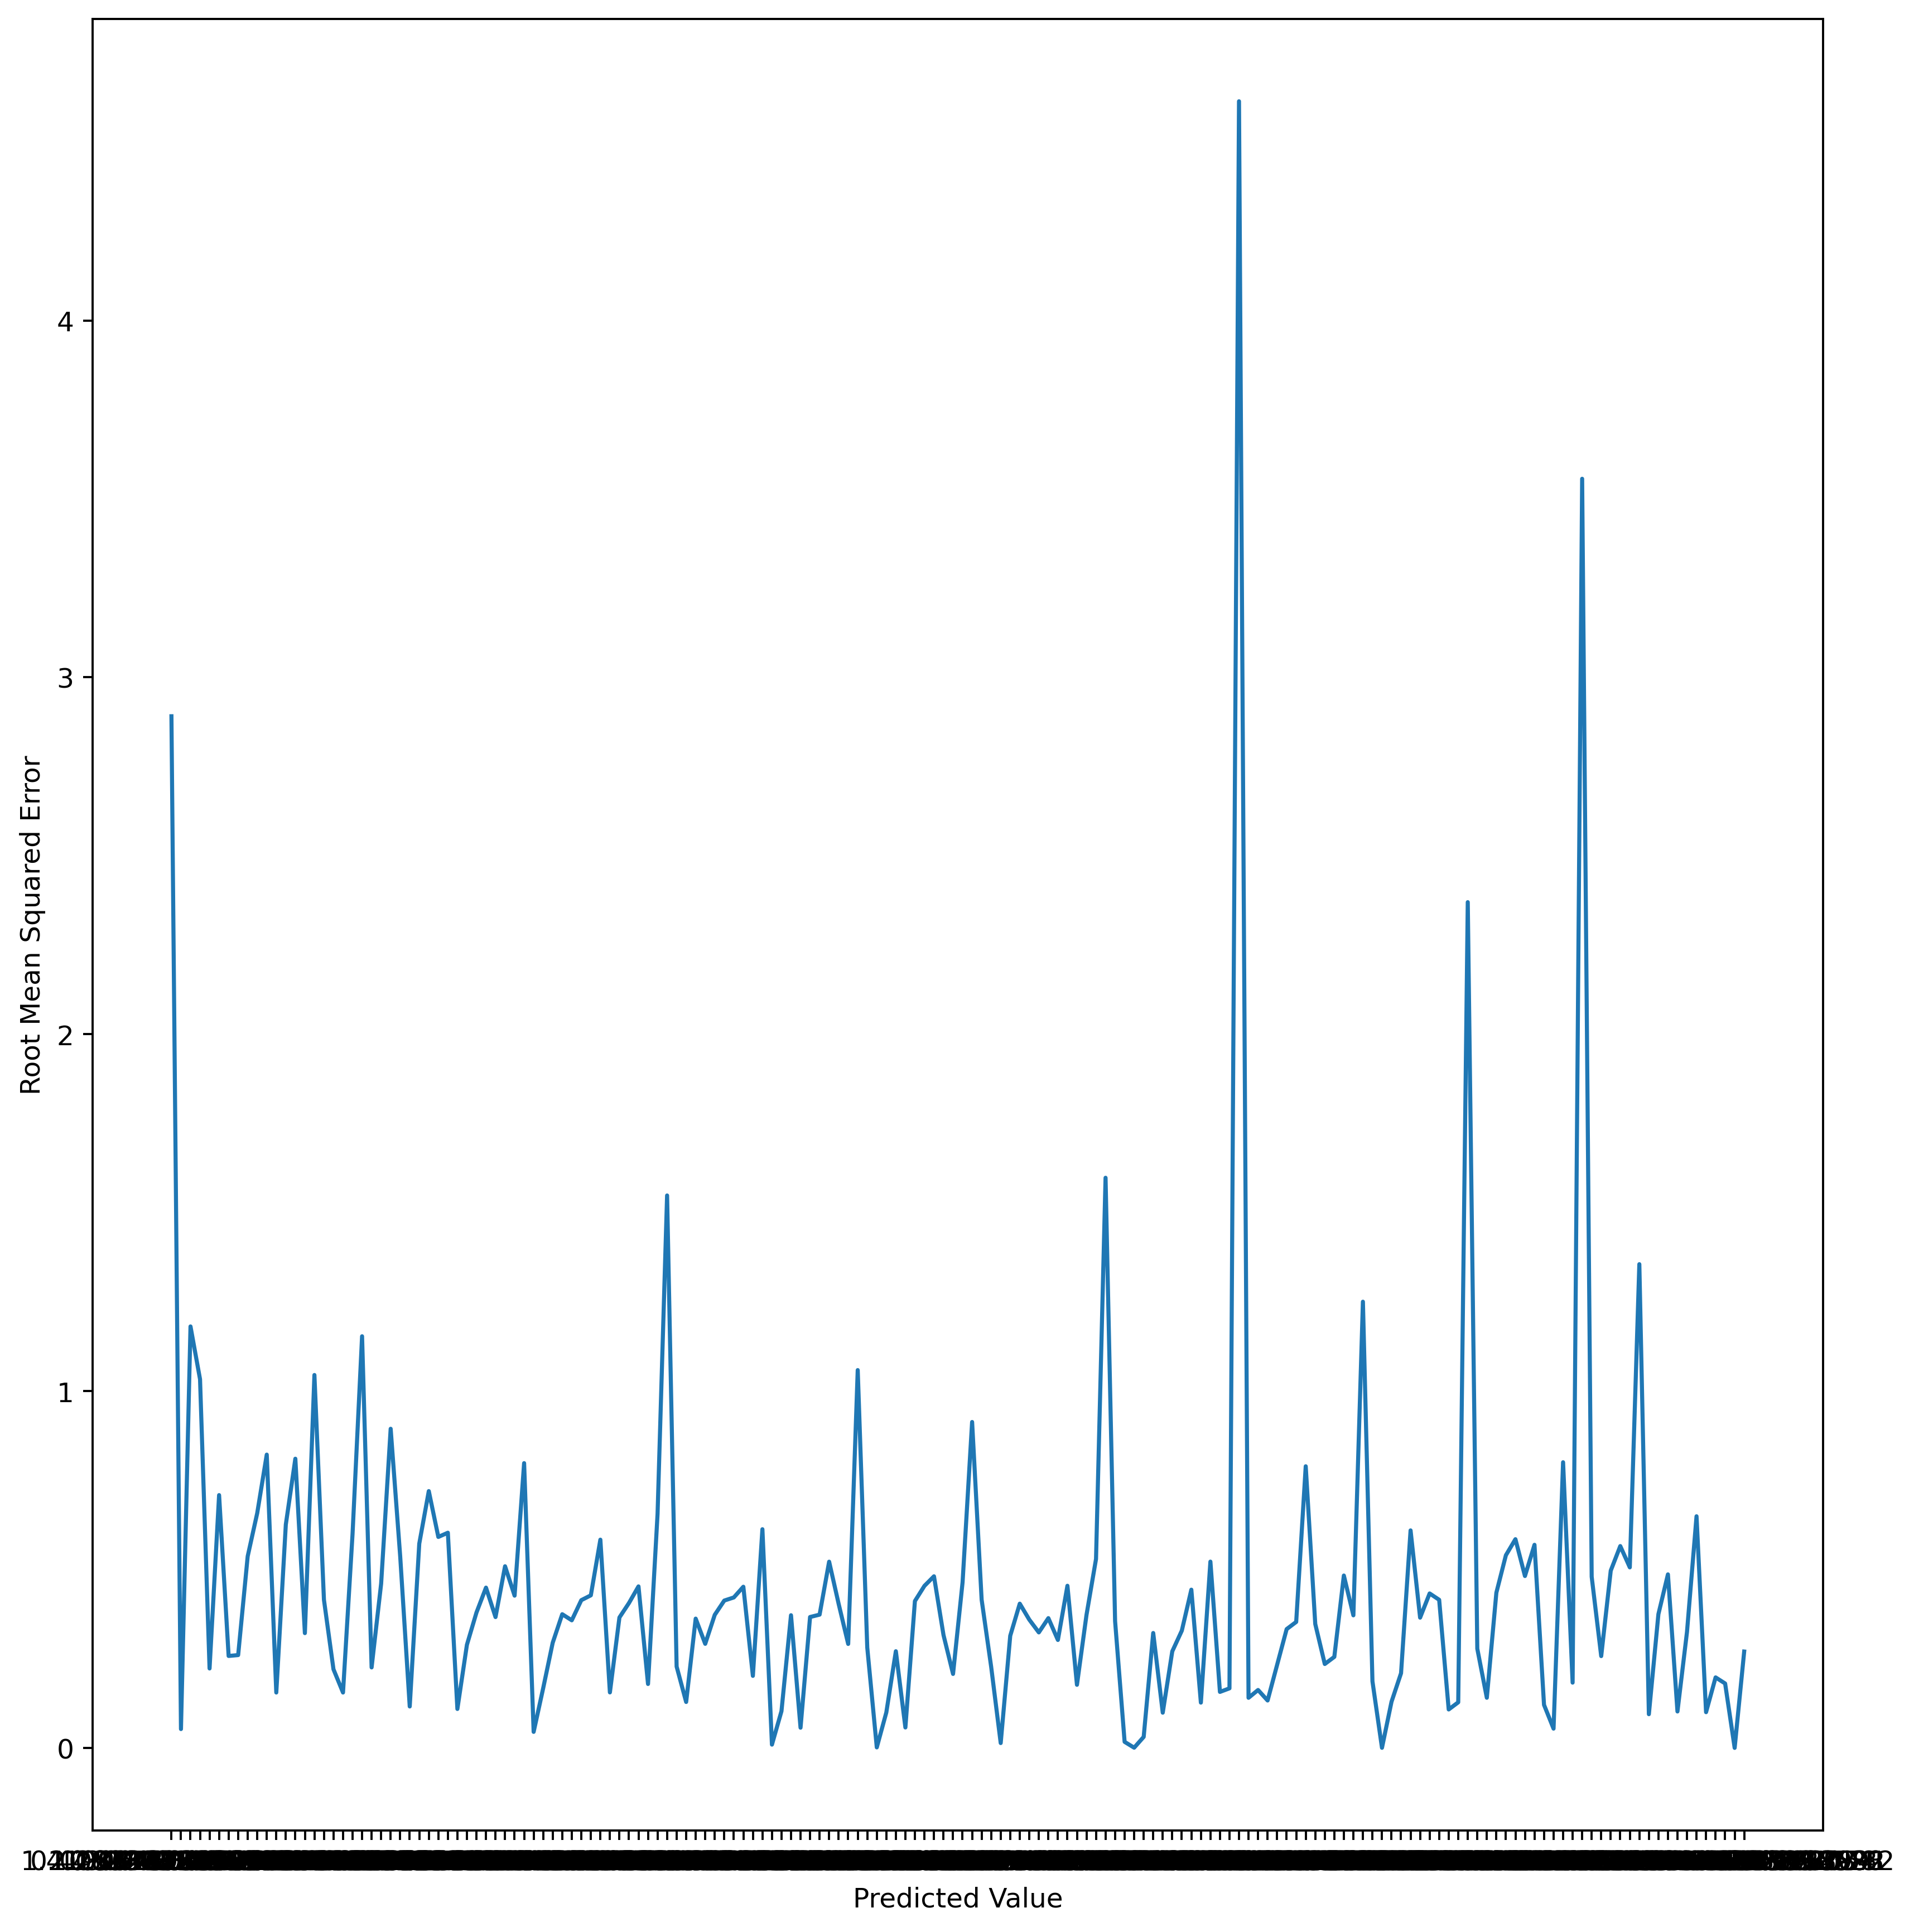

Mean root squared error:
1.5153540542096173


In [17]:
small_pred = list()
small_y = list()
    
small_errors = list()
for i in range(len(y)):
    if i % 100 == 0:      
        # calculate error
        err = math.sqrt((y[i] - predictions_data_gb[i])**2)
        # store error
        small_pred.append(predictions_data_gb[i])
        small_y.append(y[i])
        small_errors.append(err)
        # report error
        if i % 1000 == 0:
            print('>%.1f, %.1f = %.3f' % (y[i], predictions_data_gb[i], err))
# plot errors
print("number of taken elems for MSE is " + str(len(small_errors)))

fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True)  
plt.plot(small_errors)
plt.xticks(ticks=[i for i in range(len(small_errors))], labels=small_pred)
plt.xlabel('Predicted Value')
plt.ylabel('Root Mean Squared Error')
plt.show()

print("Mean root squared error:")
print(math.sqrt(metrics.mean_squared_error(y, predictions_data_gb)))

### 4.2.5. Absolute Error

Absolute error allows us to see how badly miscalculated prediction is in absolute values.

>4.3, 1.4 = 2.891
>1.4, 0.6 = 0.822
>1.7, 0.5 = 1.154
>0.5, 0.6 = 0.109
>0.2, 0.5 = 0.295
>0.1, 0.2 = 0.179
>0.0, 0.5 = 0.452
>0.0, 0.4 = 0.404
>0.1, 0.5 = 0.481
>0.2, 0.5 = 0.360
>0.6, 0.6 = 0.017
>0.0, 0.2 = 0.157
>0.1, 0.4 = 0.347
>0.1, 0.7 = 0.610
>0.1, 0.6 = 0.540
>0.3, 0.5 = 0.257
>0.8, 0.2 = 0.649
number of taken elems for MSE is 166


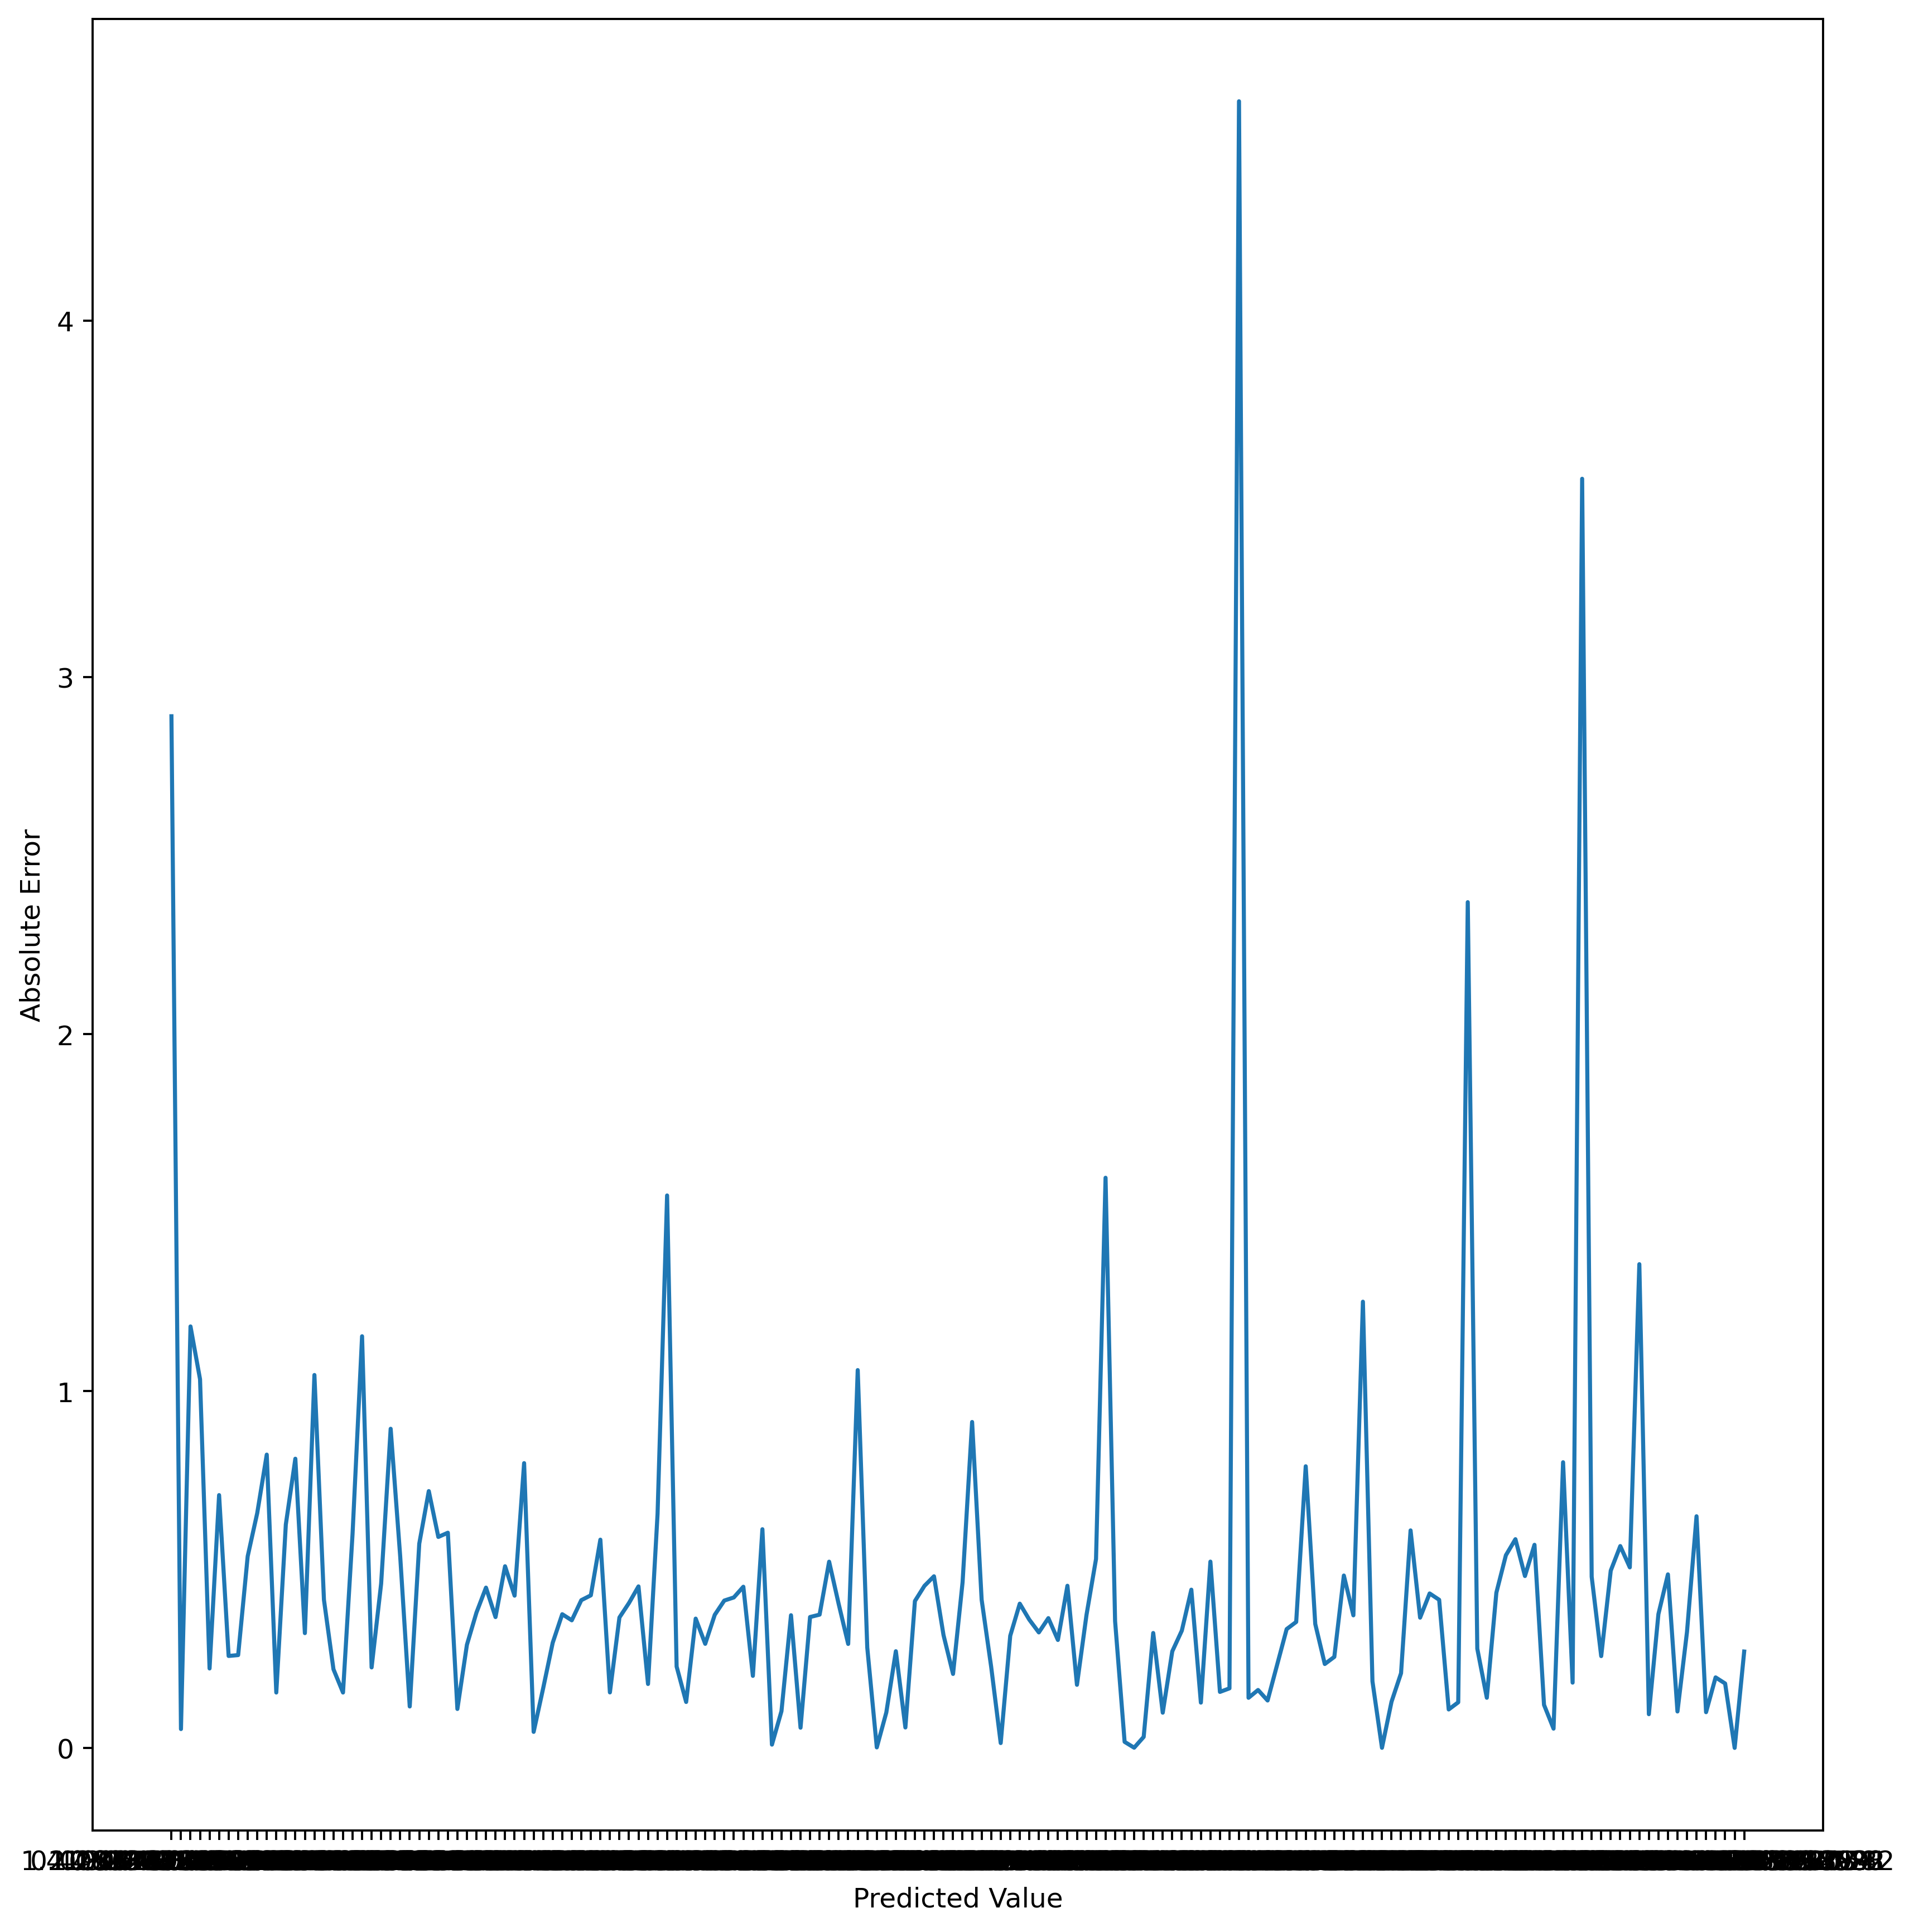

Mean absolute error:
0.5594975769671213


In [18]:
small_pred = list()
small_y = list()
    
small_errors = list()
for i in range(len(y)):
    if i % 100 == 0:      
        # calculate error
        err = abs(y[i] - predictions_data_gb[i])
        # store error
        small_pred.append(predictions_data_gb[i])
        small_y.append(y[i])
        small_errors.append(err)
        # report error
        if i % 1000 == 0:
            print('>%.1f, %.1f = %.3f' % (y[i], predictions_data_gb[i], err))
# plot errors
print("number of taken elems for MSE is " + str(len(small_errors)))

fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True)  
plt.plot(small_errors)
plt.xticks(ticks=[i for i in range(len(small_errors))], labels=small_pred)
plt.xlabel('Predicted Value')
plt.ylabel('Absolute Error')
plt.show()

print("Mean absolute error:")
print(metrics.mean_absolute_error(y, predictions_data_gb))

### 4.2.6. Coefficient of Determination

CoD for this technique and dataset says that the model is dependant on one attribute much more, than on the others and therefore we have dependent attributes.

In [19]:
print("Coefficient of determination of GBR on VGSales dataset is " + str(metrics.r2_score(y, predictions_data_gb)))

Coefficient of determination of GBR on VGSales dataset is 0.0503184387686495


# Comparison of Random Forest and Gradient Boosting Techniques

After fitting a number of different regression or time series forecasting models to a given data set, you have many criteria by which they can be compared:

Error measures in the estimation period: root mean squared error, mean absolute error, mean absolute percentage error, mean absolute scaled error, mean error, mean percentage error
Error measures in the validation period (if you have done out-of-sample testing): Ditto
Residual diagnostics and goodness-of-fit tests: plots of actual and predicted values; plots of residuals versus time, versus predicted values, and versus other variables; residual autocorrelation plots, cross-correlation plots, and tests for normally distributed errors; measures of extreme or influential observations; tests for excessive runs, changes in mean, or changes in variance (lots of things that can be "OK" or "not OK")
Qualitative considerations: intuitive reasonableness of the model, simplicity of the model, and above all, usefulness for decision making!
https://people.duke.edu/~rnau/compare.htm

### 5.1. Feature Importances

Feature importance can show us that whilst Random Forest weights all of the attributes more or less equal with a slight dominance of platforms, and Gradient Boosting is mostly relying on the platforms and almost ignores publishers.

In [20]:
importances_rf_new = list()
for i in feature_importances_rf:
    importances_rf_new.append(i[1])
    
importances_gb_new = list()
for i in feature_importances_gb:
    importances_gb_new.append(i[1])

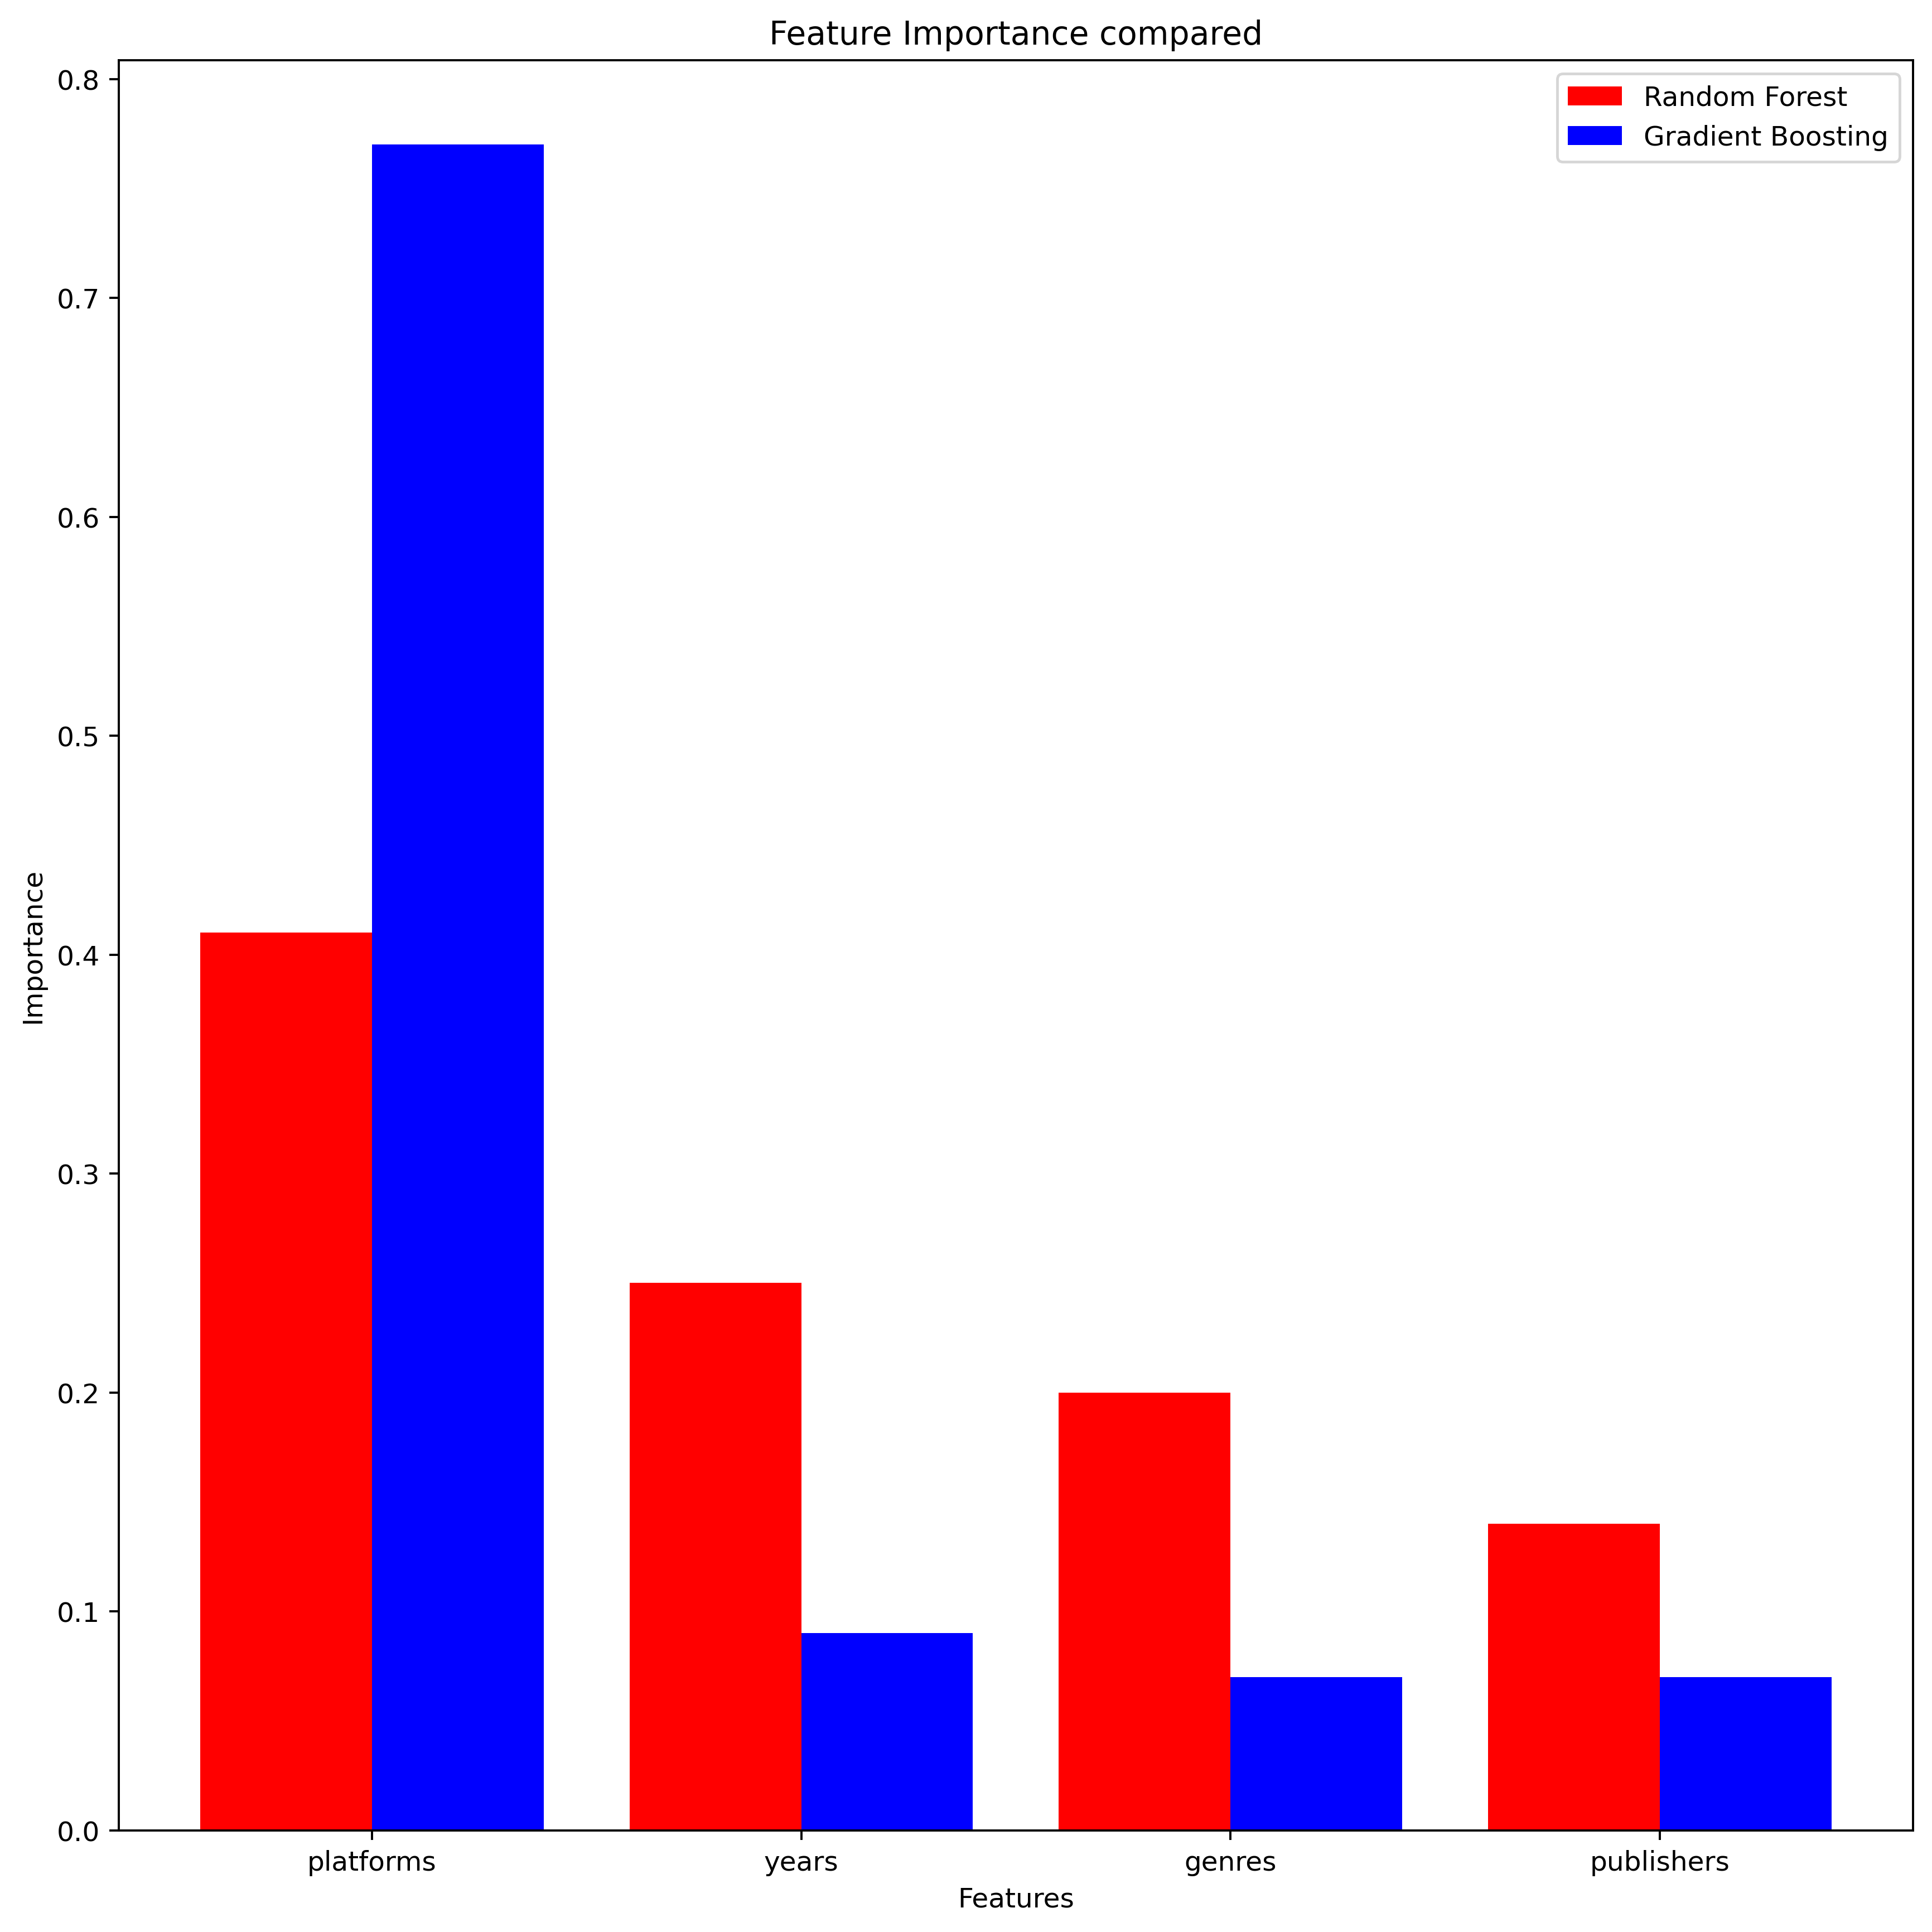

In [21]:
width = 0.4
x = np.arange(4)
# plot bars in stack manner

fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True)  
plt.bar(x-0.2, importances_rf_new, width, color='r')
plt.bar(x+0.2, importances_gb_new, width, color='b')
plt.xticks(x, feature_list)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.legend(["Random Forest", "Gradient Boosting"])
plt.title("Feature Importance compared")
plt.show()

### 5.2. Results Comparison

Scatter plot of prediction comparisons show us that most of the predicted data is correct, and by the following we ignore outliers.

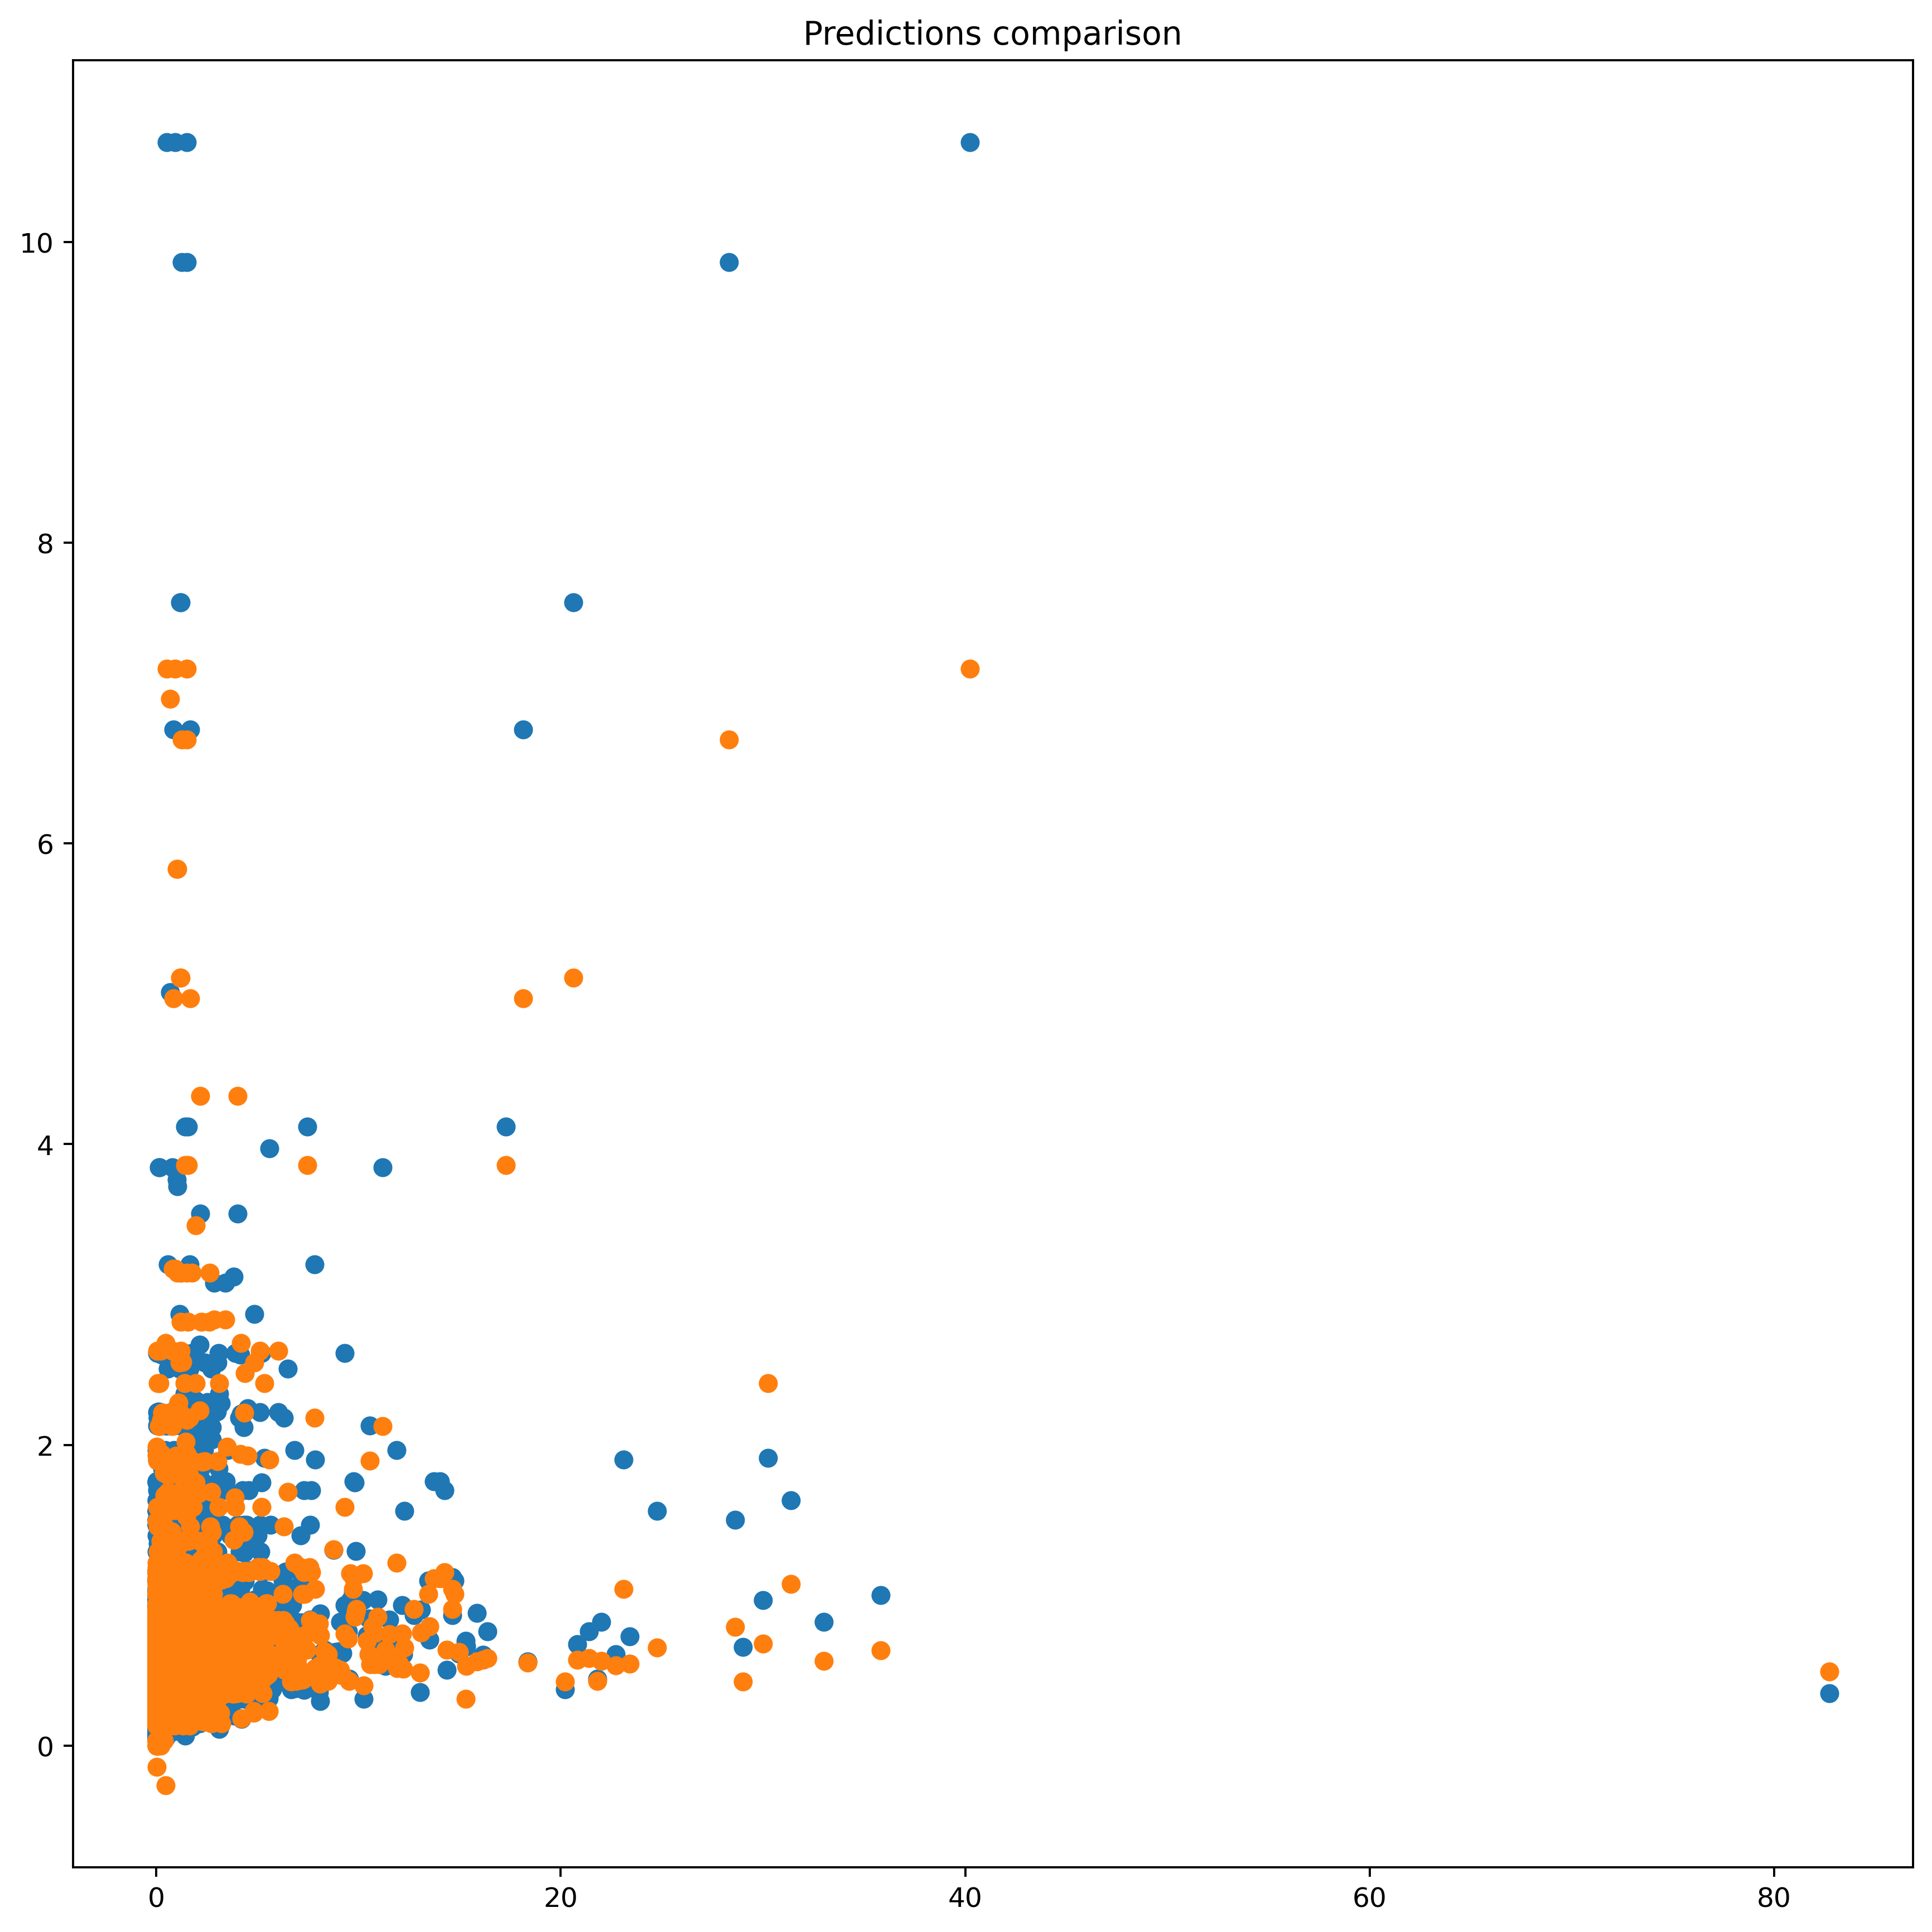

In [22]:

fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True)  
plt.scatter(y, predictions_data_rf)
plt.scatter(y, predictions_data_gb)
plt.title("Predictions comparison")
plt.show()

### 5.3 More of prediction comparison

Below the comparison of two prediction sets and the actual data set is shown on the plot.

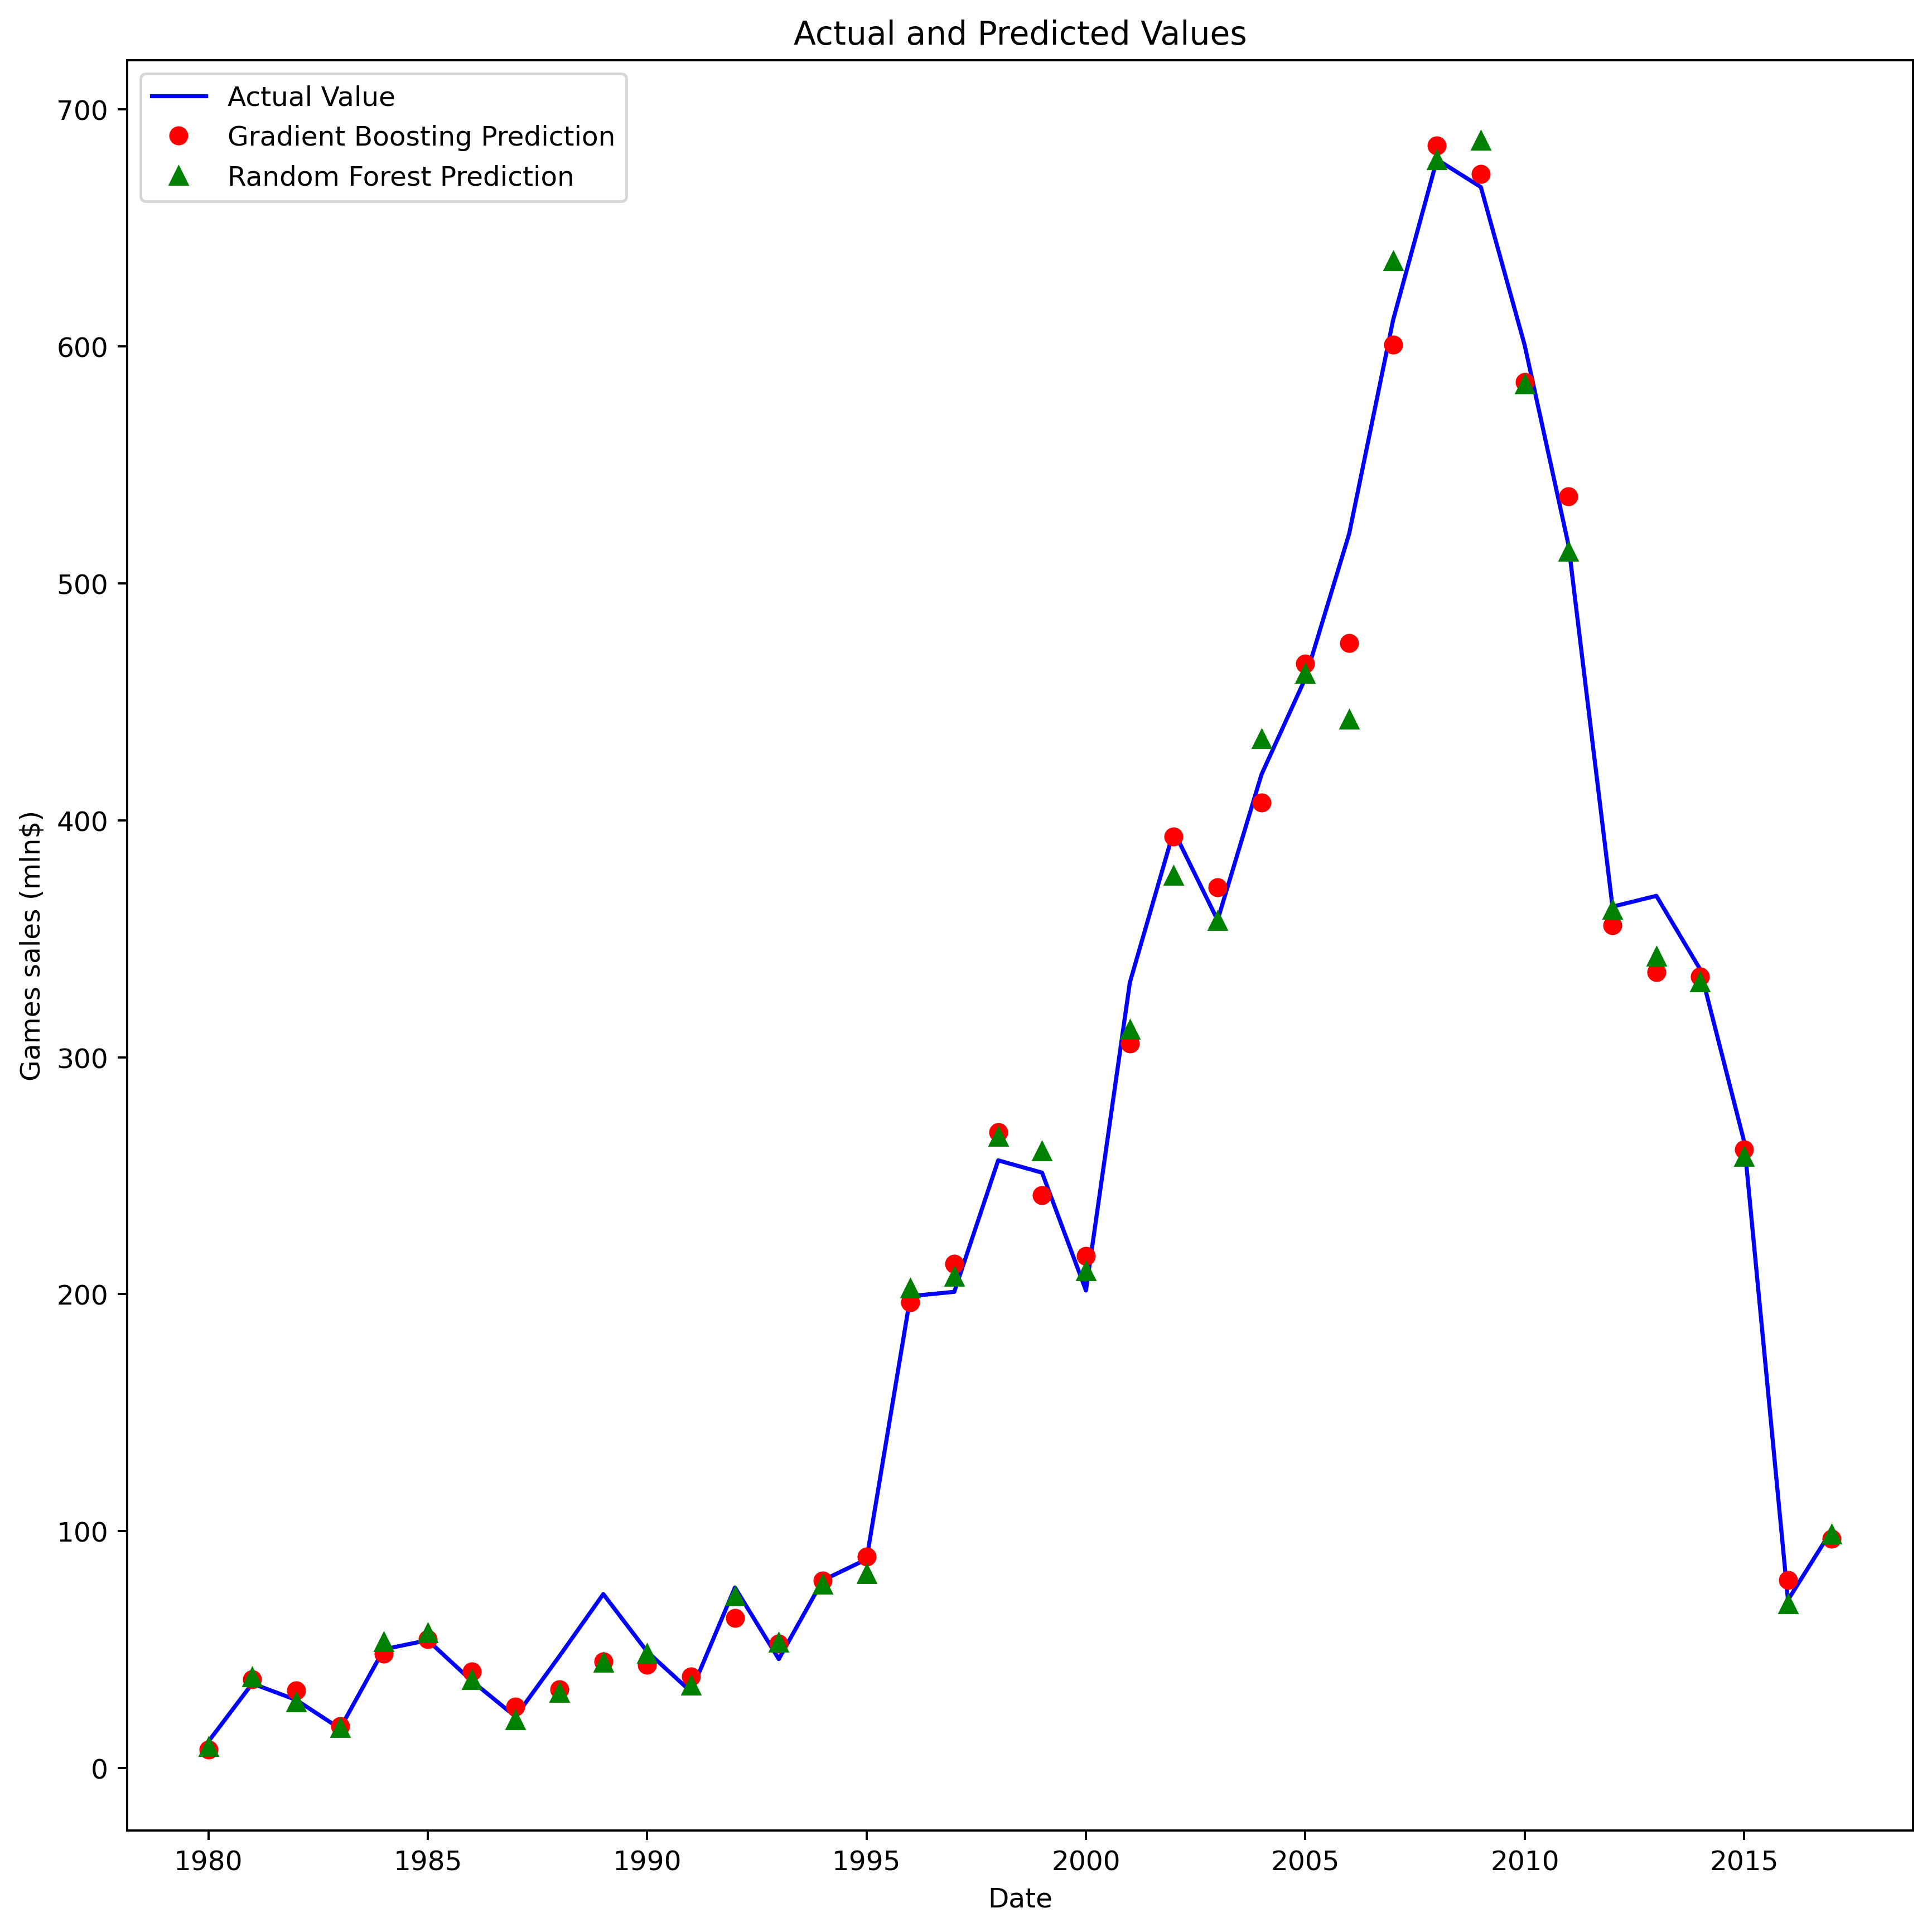

In [23]:

fig = plt.figure(figsize=(10, 10), dpi=350, tight_layout=True)    
plt.plot(yrs, sum_by_years_actual_gb, 'b-', label = 'Actual Value')
plt.plot(yrs, sum_by_years_pred_gb, 'ro', label = 'Gradient Boosting Prediction')
plt.plot(yrs, sum_by_years_pred_rf, 'g^', label = 'Random Forest Prediction')
plt.legend()
plt.xlabel('Date'); plt.ylabel('Games sales (mln$)'); plt.title('Actual and Predicted Values');

### 5.4 Mean Absolute Percentage Error

The mean absolute percentage error (MAPE) is a measure of how precise a DM technique is. It measures this accuracy as a percentage, and can be calculated as the average absolute percent error for each time period minus actual values divided by actual values.

In [24]:
print("Random Forest MAPE")
print(metrics.mean_absolute_percentage_error(y, rf_most_important.predict(X[:,important_indices])))
print("Gradient Boosting MAPE")
print(metrics.mean_absolute_percentage_error(y, gb_most_important.predict(X[:,important_indices])))

Random Forest MAPE
5.468706028821381
Gradient Boosting MAPE
5.6941559062538065


### 5.5 Mean Absolute Error

Shows us the biggest deviations in the absolute values in average for the whole data set.

In [25]:
print("Random Forest MAE")
print(metrics.mean_absolute_error(y, rf_most_important.predict(X[:,important_indices])))
print("Gradient Boosting MAE")
print(metrics.mean_absolute_error(y, gb_most_important.predict(X[:,important_indices])))

Random Forest MAE
0.5563061863912188
Gradient Boosting MAE
0.5594975769671213


### 5.6 Explained variance scores

The explained variance score explains the dispersion of errors of given dataset and prediction technique.

In [26]:
print("Explained variance score of Random forest prediction:")
print(metrics.explained_variance_score(y, rf_most_important.predict(X[:,important_indices])))
print("Explained variance score of Gradient boosting prediction:")
print(metrics.explained_variance_score(y, gb_most_important.predict(X[:,important_indices])))

Explained variance score of Random forest prediction:
0.06255468132202979
Explained variance score of Gradient boosting prediction:
0.050330446149537966


### 5.7. Total comparison

Everything what we have described above is collected in a suitable table form to observe the differences.

In [27]:
#mse
#rmse
#mase
#mape
#coef
#explainedVarScores
#mostImportantElement
type = ["Mean squared error",
        "Root mean squared error", 
        "Mean absolute error",
        "Mean absolute percentage error",
        "Coefficient of Determination",
        "Explained Variance Score",
        'most important attribute']
rf = [
      metrics.mean_squared_error(y, predictions_data_rf), 
      math.sqrt(metrics.mean_squared_error(y, predictions_data_rf)), 
      metrics.mean_absolute_error(y, predictions_data_rf), 
      metrics.mean_absolute_percentage_error(y, predictions_data_rf), 
      metrics.r2_score(y, predictions_data_rf), 
      metrics.explained_variance_score(y, predictions_data_rf),
      'years']
gb = [ 
      metrics.mean_squared_error(y, predictions_data_gb),
      math.sqrt(metrics.mean_squared_error(y, predictions_data_gb)),
      metrics.mean_absolute_error(y, predictions_data_gb),
      metrics.mean_absolute_percentage_error(y, predictions_data_gb),
      metrics.r2_score(y, predictions_data_gb),
      metrics.explained_variance_score(y, predictions_data_gb),
      'publishers'
]

table = pd.DataFrame(list(zip(type,rf,gb)))
table.columns = ['Type', 'Random Forest', 'Gradient Boosting']
table

Type Random Forest Gradient Boosting
0              Mean squared error      2.266747          2.296298
1         Root mean squared error      1.505572          1.515354
2             Mean absolute error      0.556306          0.559498
3  Mean absolute percentage error      5.468706          5.694156
4    Coefficient of Determination       0.06254          0.050318
5        Explained Variance Score      0.062555           0.05033
6        most important attribute         years        publishers

Thank you for the attention!